# [1.1] - Transformers from scratch (exercises)

> **ARENA [Streamlit Page](https://arena-chapter1-transformer-interp.streamlit.app/01_[1.1]_Transformer_from_Scratch)**
>
> **Colab: [exercises](https://colab.research.google.com/github/callummcdougall/ARENA_3.0/blob/main/chapter1_transformer_interp/exercises/part1_transformer_from_scratch/1.1_Transformer_from_Scratch_exercises.ipynb?t=20250915) | [solutions](https://colab.research.google.com/github/callummcdougall/ARENA_3.0/blob/main/chapter1_transformer_interp/exercises/part1_transformer_from_scratch/1.1_Transformer_from_Scratch_solutions.ipynb?t=20250915)**

Please send any problems / bugs on the `#errata` channel in the [Slack group](https://join.slack.com/t/arena-uk/shared_invite/zt-3afdmdhye-Mdb3Sv~ss_V_mEaXEbkABA), and ask any questions on the dedicated channels for this chapter of material.

You can collapse each section so only the headers are visible, by clicking the arrow symbol on the left hand side of the markdown header cells.

Links to all other chapters: [(0) Fundamentals](https://arena-chapter0-fundamentals.streamlit.app/), [(1) Transformer Interpretability](https://arena-chapter1-transformer-interp.streamlit.app/), [(2) RL](https://arena-chapter2-rl.streamlit.app/).

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/headers/header-11.png" width="350">

# Introduction

This is a clean, first principles implementation of GPT-2 in PyTorch. The architectural choices closely follow those used by the TransformerLens library (which you'll be using a lot more in later exercises).

The exercises are written to accompany Neel Nanda's [TransformerLens library](https://github.com/neelnanda-io/TransformerLens) for doing mechanistic interpretability research on GPT-2 style language models. We'll be working with this library extensively in this chapter of the course.

Each exercise will have a difficulty and importance rating out of 5, as well as an estimated maximum time you should spend on these exercises and sometimes a short annotation. You should interpret the ratings & time estimates relatively (e.g. if you find yourself spending about 50% longer on the exercises than the time estimates, adjust accordingly). Please do skip exercises / look at solutions if you don't feel like they're important enough to be worth doing, and you'd rather get to the good stuff!

For a lecture on the material today, which provides some high-level understanding before you dive into the material, watch the video below:

<iframe width="540" height="304" src="https://www.youtube.com/embed/11Z50mi8dSg" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## Content & Learning Objectives

### 1️⃣ Understanding Inputs & Outputs of a Transformer

In this section, we'll take a first look at transformers - what their function is, how information moves inside a transformer, and what inputs & outputs they take.

> ##### Learning Objectives
>
> - Understand what a transformer is used for
> - Understand causal attention, and what a transformer's output represents—algebra operations on tensors
> - Learn what tokenization is, and how models do it
> - Understand what logits are, and how to use them to derive a probability distribution over the vocabulary

### 2️⃣ Clean Transformer Implementation

Here, we'll implement a transformer from scratch, using only PyTorch's tensor operations. This will give us a good understanding of how transformers work, and how to use them. We do this by going module-by-module, in an experience which should feel somewhat similar to last week's ResNet exercises. Much like with ResNets, you'll conclude by loading in pretrained weights and verifying that your model works as expected.

> ##### Learning Objectives
>
> * Understand that a transformer is composed of attention heads and MLPs, with each one performing operations on the residual stream
> * Understand that the attention heads in a single layer operate independently, and that they have the role of calculating attention patterns (which determine where information is moved to & from in the residual stream)
> * Learn about & implement the following transformer modules:
>     * LayerNorm (transforming the input to have zero mean and unit variance)
>     * Positional embedding (a lookup table from position indices to residual stream vectors)
>     * Attention (the method of computing attention patterns for residual stream vectors)
>     * MLP (the collection of linear and nonlinear transformations which operate on each residual stream vector in the same way)
>     * Embedding (a lookup table from tokens to residual stream vectors)
>     * Unembedding (a matrix for converting residual stream vectors into a distribution over tokens)

### 3️⃣ Training a Transformer

Next, you'll learn how to train your transformer from scratch. This will be quite similar to the training loops you wrote for ResNet in your first week.

> ##### Learning Objectives
>
> * Understand how to train a transformer from scratch
> * Write a basic transformer training loop
> * Interpret the transformer's falling cross entropy loss with reference to features of the training data (e.g. bigram frequencies)

### 4️⃣ Sampling from a Transformer

Lastly, you'll learn how to sample from a transformer. This will involve implementing a few different sampling methods, and writing a caching system which can reuse computations from previous forward passes to improve your model's text generation speed.

*The second half of this section is less important, and you can skip it if you want.*

> ##### Learning Objectives
>
> * Learn how to sample from a transformer
>     * This includes basic methods like greedy search or top-k, and more advanced methods like beam search
> * Learn how to cache the output of a transformer, so that it can be used to generate text more efficiently
>     * Optionally, rewrite your sampling functions to make use of your caching methods

## Setup code

In [3]:
import os
import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

chapter = "chapter1_transformer_interp"
repo = "ARENA_3.0"
branch = "main"

# Install dependencies
try:
    import transformer_lens
except:
    %pip install transformer_lens==2.11.0 einops jaxtyping git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python

# Get root directory, handling 3 different cases: (1) Colab, (2) notebook not in ARENA repo, (3) notebook in ARENA repo
root = (
    "/content"
    if IN_COLAB
    else "/root"
    if repo not in os.getcwd()
    else str(next(p for p in Path.cwd().parents if p.name == repo))
)

if Path(root).exists() and not Path(f"{root}/{chapter}").exists():
    if not IN_COLAB:
        !sudo apt-get install unzip
        %pip install jupyter ipython --upgrade

    if not os.path.exists(f"{root}/{chapter}"):
        !wget -P {root} https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/{branch}.zip
        !unzip {root}/{branch}.zip '{repo}-{branch}/{chapter}/exercises/*' -d {root}
        !mv {root}/{repo}-{branch}/{chapter} {root}/{chapter}
        !rm {root}/{branch}.zip
        !rmdir {root}/ARENA_3.0-{branch}


if f"{root}/{chapter}/exercises" not in sys.path:
    sys.path.append(f"{root}/{chapter}/exercises")

os.chdir(f"{root}/{chapter}/exercises")

In [27]:
import math
import os
import sys
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path
from typing import Callable

import datasets
import einops
import numpy as np
import torch as t
import torch.nn as nn
import wandb
from jaxtyping import Float, Int
from rich import print as rprint
from rich.table import Table
from torch import Tensor
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from transformer_lens import HookedTransformer
from transformer_lens.utils import gelu_new, tokenize_and_concatenate
from transformers.models.gpt2.tokenization_gpt2_fast import GPT2TokenizerFast
import matplotlib.pyplot as plt

device = t.device(
    "mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu"
)

# Make sure exercises are in the path
chapter = "chapter1_transformer_interp"
section = "part1_transformer_from_scratch"
root_dir = next(p for p in Path.cwd().parents if (p / chapter).exists())
exercises_dir = root_dir / chapter / "exercises"
section_dir = exercises_dir / section

import part1_transformer_from_scratch.solutions as solutions
import part1_transformer_from_scratch.tests as tests
from plotly_utils import imshow

MAIN = __name__ == "__main__"

# 1️⃣ Understanding Inputs & Outputs of a Transformer

> ##### Learning Objectives
>
> - Understand what a transformer is used for
> - Understand causal attention, and what a transformer's output represents—algebra operations on tensors
> - Learn what tokenization is, and how models do it
> - Understand what logits are, and how to use them to derive a probability distribution over the vocabulary

## What is the point of a transformer?

**Transformers exist to model text!**

We're going to focus GPT-2 style transformers. Key feature: They generate text! You feed in language, and the model generates a probability distribution over tokens. And you can repeatedly sample from this to generate text!

(To explain this in more detail - you feed in a sequence of length $N$, then sample from the probability distribution over the $N+1$-th word, use this to construct a new sequence of length $N+1$, then feed this new sequence into the model to get a probability distribution over the $N+2$-th word, and so on.)

### How is the model trained?

You give it a bunch of text, and train it to predict the next token.

Importantly, if you give a model 100 tokens in a sequence, it predicts the next token for *each* prefix, i.e. it produces 100 logit vectors (= probability distributions) over the set of all words in our vocabulary, with the `i`-th logit vector representing the probability distribution over the token *following* the `i`-th token in the sequence. This is a key part of what allows transformers to be trained so efficiently; for every sequence of length $n$ we get $n$ different predictions to train on:

$$
p(x_1), \; p(x_2|x_1), \; p(x_3|x_1x_2), \; \ldots, \; p(x_n|x_1 \ldots x_{n-1})
$$

<details>
<summary>Aside - logits</summary>

If you haven't encountered the term "logits" before, here's a quick refresher.

Given an arbitrary vector $x$, we can turn it into a probability distribution via the **softmax** function: $x_i \to \frac{e^{x_i}}{\sum e^{x_j}}$. The exponential makes everything positive; the normalization makes it add to one.

The model's output is the vector $x$ (one for each prediction it makes). We call this vector a logit because it represents a probability distribution, and it is related to the actual probabilities via the softmax function.
</details>

How do we stop the transformer by "cheating" by just looking at the tokens it's trying to predict? Answer - we make the transformer have *causal attention* (as opposed to *bidirectional attention*). Causal attention only allows information to move forwards in the sequence, never backwards. The prediction of what comes after token 50 is only a function of the first 50 tokens, *not* of token 51. We say the transformer is **autoregressive**, because it only predicts future words based on past data.

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/transformer-overview-new.png" width="900">

Another way to view this is through the following analogy: we have a series of people standing in a line, each with one word or chunk of the sentence. Each person has the ability to look up information from the people behind them (we'll explore how this works in later sections) but they can't look at any information in front of them. Their goal is to guess what word the person in front of them is holding.

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/intro-image-v2.png" width="600">

## Tokens - Transformer Inputs

Our tranformer's input is natural language (i.e. a sequence of characters, strings, etc). But ML models generally take vectors as input, not language. How do we convert language to vectors?

We can factor this into 2 questions:

1. How do we split up language into small sub-units?
2. How do we convert these sub-units into vectors?

Let's start with the second of these questions.

### Converting sub-units to vectors

We basically make a massive lookup table, which is called an **embedding**. It has one vector for each possible sub-unit of language we might get (we call this set of all sub-units our **vocabulary**). We label every element in our vocabulary with an integer (this labelling never changes), and we use this integer to index into the embedding.

A key intuition is that one-hot encodings let you think about each integer independently. We don't bake in any relation between words when we perform our embedding, because every word has a completely separate embedding vector.

<details>
<summary>Aside - one-hot encodings</summary>

We sometimes think about **one-hot encodings** of words. These are vectors with zeros everywhere, except for a single one in the position corresponding to the word's index in the vocabulary. This means that indexing into the embedding is equivalent to multiplying the **embedding matrix** by the one-hot encoding (where the embedding matrix is the matrix we get by stacking all the embedding vectors on top of each other).

$$
\begin{aligned}
W_E &= \begin{bmatrix}
\leftarrow v_0 \rightarrow \\
\leftarrow v_1 \rightarrow \\
\vdots \\
\leftarrow v_{d_{vocab}-1} \rightarrow \\
\end{bmatrix} \quad \text{is the embedding matrix (size }d_{vocab} \times d_{embed}\text{),} \\
\\
t_i &= (0, \dots, 0, 1, 0, \dots, 0) \quad \text{is the one-hot encoding for the }i\text{th word (length }d_{vocab}\text{)} \\
\\
v_i &= t_i W_E \quad \text{is the embedding vector for the }i\text{th word (length }d_{embed}\text{).} \\
\end{aligned}
$$

</details>

Now, let's answer the first question - how do we split language into sub-units?

### Splitting language into sub-units

We need to define a standard way of splitting up language into a series of substrings, where each substring is a member of our **vocabulary** set.

Could we use a dictionary, and have our vocabulary be the set of all words in the dictionary? No, because this couldn't handle arbitrary text (e.g. URLs, punctuation, etc). We need a more general way of splitting up language.

Could we just use the 256 ASCII characters? This fixes the previous problem, but it loses structure of language - some sequences of characters are more meaningful than others. For example, "language" is a lot more meaningful than "hjksdfiu". We want "language" to be a single token, but not "hjksdfiu" - this is a more efficient use of our vocab.

What actually happens? The most common strategy is called **Byte-Pair encodings**.

We begin with the 256 ASCII characters as our tokens, and then find the most common pair of tokens, and merge that into a new token. Note that we do have a space character as one of our 256 tokens, and merges using space are very common. For instance, here are the five first merges for the tokenizer used by GPT-2 (you'll be able to verify this below).

```
" t"
" a"
"he"
"in"
"re"
```

Note - you might see the character `Ġ` in front of some tokens. This is a special token that indicates that the token begins with a space. Tokens with a leading space vs not are different.

You can run the code below to load in the `gpt2-small` model, and see more of its tokenizer's vocabulary:

In [5]:
reference_gpt2 = HookedTransformer.from_pretrained(
    "gpt2-small",
    fold_ln=False,
    center_unembed=False,
    center_writing_weights=False,  # you'll learn about these arguments later!
)

sorted_vocab = sorted(list(reference_gpt2.tokenizer.vocab.items()), key=lambda n: n[1])

print(sorted_vocab[:20])
print()
print(sorted_vocab[250:270])
print()
print(sorted_vocab[990:1010])
print()

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer
[('!', 0), ('"', 1), ('#', 2), ('$', 3), ('%', 4), ('&', 5), ("'", 6), ('(', 7), (')', 8), ('*', 9), ('+', 10), (',', 11), ('-', 12), ('.', 13), ('/', 14), ('0', 15), ('1', 16), ('2', 17), ('3', 18), ('4', 19)]

[('ľ', 250), ('Ŀ', 251), ('ŀ', 252), ('Ł', 253), ('ł', 254), ('Ń', 255), ('Ġt', 256), ('Ġa', 257), ('he', 258), ('in', 259), ('re', 260), ('on', 261), ('Ġthe', 262), ('er', 263), ('Ġs', 264), ('at', 265), ('Ġw', 266), ('Ġo', 267), ('en', 268), ('Ġc', 269)]

[('Ġprodu', 990), ('Ġstill', 991), ('led', 992), ('ah', 993), ('Ġhere', 994), ('Ġworld', 995), ('Ġthough', 996), ('Ġnum', 997), ('arch', 998), ('imes', 999), ('ale', 1000), ('ĠSe', 1001), ('ĠIf', 1002), ('//', 1003), ('ĠLe', 1004), ('Ġret', 1005), ('Ġref', 1006), ('Ġtrans', 1007), ('ner', 1008), ('ution', 1009)]



As you get to the end of the vocabulary, you'll be producing some pretty weird-looking esoteric tokens (because you'll already have exhausted all of the short frequently-occurring ones):

In [6]:
print(sorted_vocab[-20:])

[('Revolution', 50237), ('Ġsnipers', 50238), ('Ġreverted', 50239), ('Ġconglomerate', 50240), ('Terry', 50241), ('794', 50242), ('Ġharsher', 50243), ('Ġdesolate', 50244), ('ĠHitman', 50245), ('Commission', 50246), ('Ġ(/', 50247), ('âĢ¦."', 50248), ('Compar', 50249), ('Ġamplification', 50250), ('ominated', 50251), ('Ġregress', 50252), ('ĠCollider', 50253), ('Ġinformants', 50254), ('Ġgazed', 50255), ('<|endoftext|>', 50256)]


<details>
<summary>Fun (completely optional) exercise - can you guess what the first-formed 3/4/5/6/7-letter encodings in GPT-2's vocabulary are?</summary>
Run this code to find out:

```python
lengths = dict.fromkeys(range(3, 8), "")
for tok, idx in sorted_vocab:
    if not lengths.get(len(tok), True):
        lengths[len(tok)] = tok

for length, tok in lengths.items():
    print(f"{length}: {tok}")
```
</details>

[('!', 0), ('"', 1), ('#', 2), ('$', 3), ('%', 4), ('&', 5), ("'", 6), ('(', 7), (')', 8), ('*', 9), ('+', 10), (',', 11), ('-', 12), ('.', 13), ('/', 14), ('0', 15), ('1', 16), ('2', 17), ('3', 18), ('4', 19)]

[('ľ', 250), ('Ŀ', 251), ('ŀ', 252), ('Ł', 253), ('ł', 254), ('Ń', 255), ('Ġt', 256), ('Ġa', 257), ('he', 258), ('in', 259), ('re', 260), ('on', 261), ('Ġthe', 262), ('er', 263), ('Ġs', 264), ('at', 265), ('Ġw', 266), ('Ġo', 267), ('en', 268), ('Ġc', 269)]

[('Ġprodu', 990), ('Ġstill', 991), ('led', 992), ('ah', 993), ('Ġhere', 994), ('Ġworld', 995), ('Ġthough', 996), ('Ġnum', 997), ('arch', 998), ('imes', 999), ('ale', 1000), ('ĠSe', 1001), ('ĠIf', 1002), ('//', 1003), ('ĠLe', 1004), ('Ġret', 1005), ('Ġref', 1006), ('Ġtrans', 1007), ('ner', 1008), ('ution', 1009)]

[3.0683786869049072, 3.0900771617889404, 3.5134739875793457, 3.6932809352874756, 3.2104291915893555, 3.5588982105255127, 3.301699638366699, 3.0861237049102783, 3.076545476913452, 3.300140619277954, 3.373624086380005

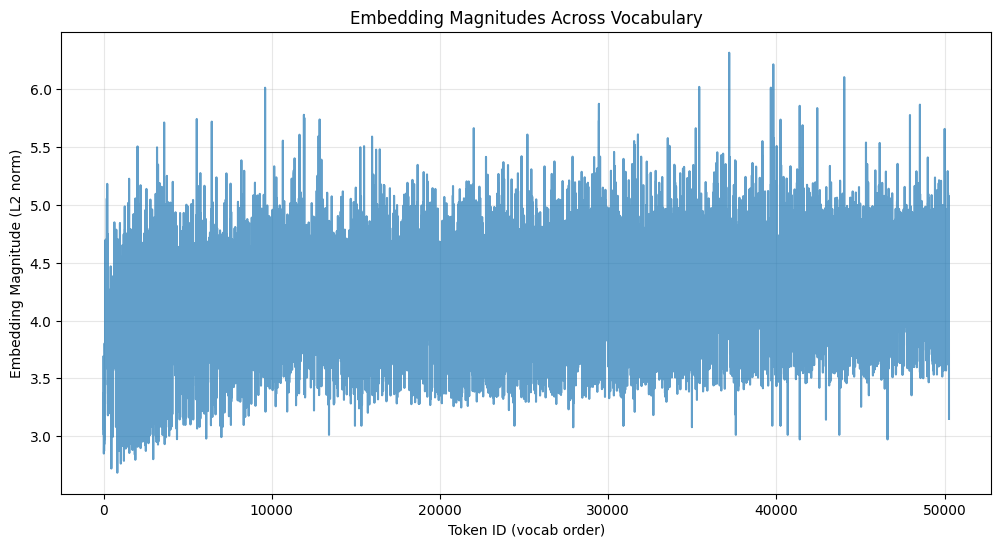

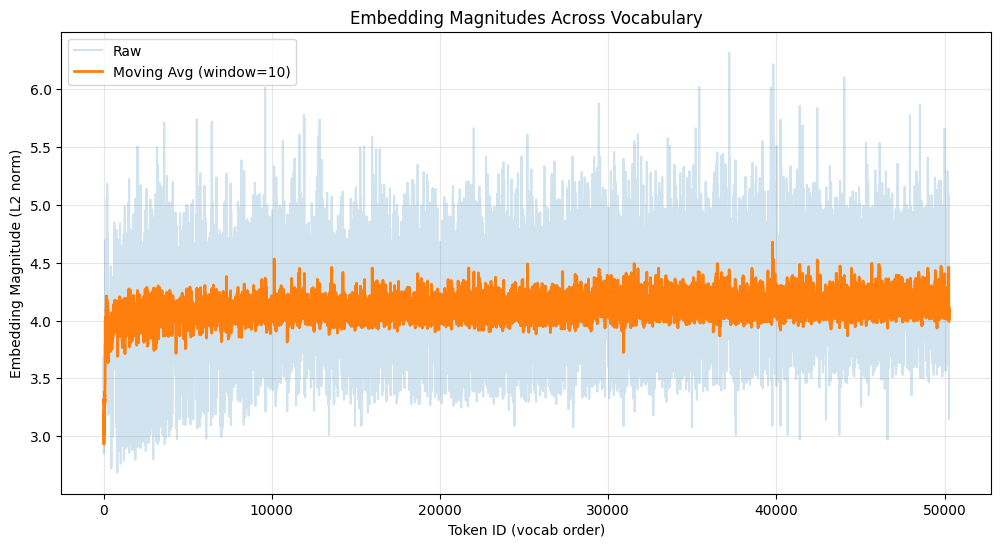

In [36]:
sorted_vocab = sorted(list(reference_gpt2.tokenizer.vocab.items()), key=lambda n: n[1])

print(sorted_vocab[:20])
print()
print(sorted_vocab[250:270])
print()
print(sorted_vocab[990:1010])
print()


sorted_embeddings = [reference_gpt2.embed.W_E[reference_gpt2.tokenizer.encode(token[0])[0]]  for token in sorted_vocab]
norms = [emb.norm().item() for emb in sorted_embeddings]
print(norms)


plt.figure(figsize=(12, 6))
plt.plot(norms, alpha=0.7)
plt.xlabel("Token ID (vocab order)")
plt.ylabel("Embedding Magnitude (L2 norm)")
plt.title("Embedding Magnitudes Across Vocabulary")
plt.grid(True, alpha=0.3)
plt.show()

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 10  # Adjust this for more/less smoothing
norms_smoothed = moving_average(norms, window_size)

plt.figure(figsize=(12, 6))
plt.plot(norms, alpha=0.2, label='Raw')
plt.plot(range(window_size-1, len(norms)), norms_smoothed, label=f'Moving Avg (window={window_size})', linewidth=2)
plt.xlabel("Token ID (vocab order)")
plt.ylabel("Embedding Magnitude (L2 norm)")
plt.title("Embedding Magnitudes Across Vocabulary")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [25]:
# semantic arithmetic
token1, token2, token3 = "man", "woman", "king"
token1_id = reference_gpt2.tokenizer.encode(token1)[0] # get token id
token2_id = reference_gpt2.tokenizer.encode(token2)[0]
token3_id = reference_gpt2.tokenizer.encode(token3)[0]
embedding1 = reference_gpt2.embed.W_E[token1_id] # get embedding vec
embedding2 = reference_gpt2.embed.W_E[token2_id] # get embedding vec
embedding3 = reference_gpt2.embed.W_E[token3_id]
token_diff = embedding2 - embedding1
print(token_diff.shape)
print(embedding3.shape)
new_token_embedding = embedding3 + token_diff

logits = new_token_embedding @ reference_gpt2.unembed.W_U # cosine sim between embedding and each token's embedding, higher magnitude, logits?
print(f"Logits shape: {logits.shape}")
print(f"Logits (first 10): {logits[:10]}")
print()
top_k = 5
top_token_ids = logits.topk(top_k).indices
top_logits = logits.topk(top_k).values


print(f"Top {top_k} predicted tokens:")
for i, (tid, logit) in enumerate(zip(top_token_ids, top_logits)):
    token_str = reference_gpt2.tokenizer.decode([tid])
    print(f"  {i+1}. '{token_str}' (ID: {tid}, logit: {logit:.2f})")

# embedding1_norm = embedding1 / embedding1.norm()
# embedding2_norm = embedding2 / embedding2.norm()
# embedding3_norm = embedding3 / embedding3.norm()
# token_diff_norm = embedding2_norm - embedding1_norm
# new_embedding_norm = embedding3_norm + token_diff_norm
# logits_norm = new_embedding_norm @ reference_gpt2.embed.W_E.T
# top_token_ids = logits_norm.topk(top_k).indices
# top_logits = logits_norm.topk(top_k).values
# print(f"Top {top_k} predicted tokens:")
# for i, (tid, logit) in enumerate(zip(top_token_ids, top_logits)):
#     token_str = reference_gpt2.tokenizer.decode([tid])
#     print(f"  {i+1}. '{token_str}' (ID: {tid}, logit: {logit:.2f})")



torch.Size([768])
torch.Size([768])
Logits shape: torch.Size([50257])
Logits (first 10): tensor([2.0472, 1.9650, 3.8746, 4.3860, 3.2439, 2.9714, 2.3240, 2.3315, 1.5788,
        1.9593], device='cuda:0', grad_fn=<SliceBackward0>)

Top 5 predicted tokens:
  1. 'king' (ID: 3364, logit: 17.94)
  2. 'woman' (ID: 8580, logit: 13.33)
  3. 'ked' (ID: 9091, logit: 12.72)
  4. 'KING' (ID: 37286, logit: 12.08)
  5. 'kers' (ID: 15949, logit: 10.86)
Top 5 predicted tokens:
  1. 'king' (ID: 3364, logit: 4.16)
  2. 'ked' (ID: 9091, logit: 2.93)
  3. 'woman' (ID: 8580, logit: 2.91)
  4. 'KING' (ID: 37286, logit: 2.81)
  5. 'kers' (ID: 15949, logit: 2.45)


Transformers in the `transformer_lens` library have a `to_tokens` method that converts text to numbers. It also prepends them with a special token called BOS (beginning of sequence) to indicate the start of a sequence. You can disable this with the `prepend_bos=False` argument.

<details>
<summary>Aside - BOS token</summary>

The beginning of sequence (BOS) token is a special token used to mark the beginning of the sequence. Confusingly, in GPT-2, the End of Sequence (EOS), Beginning of Sequence (BOS) and Padding (PAD) tokens are all the same, `<|endoftext|>` with index `50256`.

Why is this token added? Some basic intuitions are:

* It provides context that this is the start of a sequence, which can help the model generate more appropriate text.
* It can act as a "rest position" for attention heads (more on this later, when we discuss attention).

TransformerLens adds this token automatically (including in forward passes of transformer models, e.g. it's implicitly added when you call `model("Hello World")`). You can disable this behaviour by setting the flag `prepend_bos=False` in `to_tokens`, `to_str_tokens`, `model.forward` and any other function that converts strings to multi-token tensors.

**Key Point: *If you get weird off-by-one errors, check whether there's an unexpected `prepend_bos`!***

Why are the BOS, EOS and PAD tokens the same? This is because GPT-2 is an autoregressive model, and uses these kinds of tokens in a slightly different way to other transformer families (e.g. BERT). For instance, GPT has no need to distinguish between BOS and EOS tokens, because it only processes text from left to right.

</details>

### Some tokenization annoyances

There are a few funky and frustrating things about tokenization, which causes it to behave differently than you might expect. For instance:

#### Whether a word begins with a capital or space matters!

In [37]:
print(reference_gpt2.to_str_tokens("Ralph"))
print(reference_gpt2.to_str_tokens(" Ralph"))
print(reference_gpt2.to_str_tokens(" ralph"))
print(reference_gpt2.to_str_tokens("ralph"))

['<|endoftext|>', 'R', 'alph']
['<|endoftext|>', ' Ralph']
['<|endoftext|>', ' r', 'alph']
['<|endoftext|>', 'ral', 'ph']


#### Arithmetic is a mess.

Length is inconsistent, common numbers bundle together.

In [38]:
print(reference_gpt2.to_str_tokens("56873+3184623=123456789-1000000000"))

['<|endoftext|>', '568', '73', '+', '318', '46', '23', '=', '123', '45', '67', '89', '-', '1', '000000', '000']


> ### Key Takeaways
>
> * We learn a dictionary of vocab of tokens (sub-words).
> * We (approx) losslessly convert language to integers via tokenizing it.
> * We convert integers to vectors via a lookup table.
> * Note: input to the transformer is a sequence of *tokens* (ie integers), not vectors

## Text generation

Now that we understand the basic ideas here, let's go through the entire process of text generation, from our original string to a new token which we can append to our string and plug back into the model.

#### **Step 1:** Convert text to tokens

The sequence gets tokenized, so it has shape `[batch, seq_len]`. Here, the batch dimension is just one (because we only have one sequence).

In [39]:
reference_text = "I am an amazing autoregressive, decoder-only, GPT-2 style transformer. One day I will exceed human level intelligence and take over the world!"
tokens = reference_gpt2.to_tokens(reference_text).to(device)
print(tokens)
print(tokens.shape)
print(reference_gpt2.to_str_tokens(tokens))

tensor([[50256,    40,   716,   281,  4998,  1960,   382, 19741,    11,   875,
         12342,    12,  8807,    11,   402, 11571,    12,    17,  3918, 47385,
            13,  1881,  1110,   314,   481,  7074,  1692,  1241,  4430,   290,
          1011,   625,   262,   995,     0]], device='cuda:0')
torch.Size([1, 35])
['<|endoftext|>', 'I', ' am', ' an', ' amazing', ' aut', 'ore', 'gressive', ',', ' dec', 'oder', '-', 'only', ',', ' G', 'PT', '-', '2', ' style', ' transformer', '.', ' One', ' day', ' I', ' will', ' exceed', ' human', ' level', ' intelligence', ' and', ' take', ' over', ' the', ' world', '!']


#### **Step 2:** Map tokens to logits


From our input of shape `[batch, seq_len]`, we get output of shape `[batch, seq_len, vocab_size]`. The `[i, j, :]`-th element of our output is a vector of logits representing our prediction for the `j+1`-th token in the `i`-th sequence.

In [40]:
logits, cache = reference_gpt2.run_with_cache(tokens)
print(logits.shape)

torch.Size([1, 35, 50257])


(`run_with_cache` tells the model to cache all intermediate activations. This isn't important right now; we'll look at it in more detail later.)

#### **Step 3:** Convert the logits to a distribution with a softmax

This doesn't change the shape, it is still `[batch, seq_len, vocab_size]`.

In [41]:
probs = logits.softmax(dim=-1)
print(probs.shape)

torch.Size([1, 35, 50257])


#### **Bonus step:** What is the most likely next token at each position?

In [42]:
most_likely_next_tokens = reference_gpt2.tokenizer.batch_decode(logits.argmax(dim=-1)[0])

print(list(zip(reference_gpt2.to_str_tokens(tokens), most_likely_next_tokens)))

[('<|endoftext|>', '\n'), ('I', "'m"), (' am', ' a'), (' an', ' avid'), (' amazing', ' person'), (' aut', 'od'), ('ore', 'sp'), ('gressive', '.'), (',', ' and'), (' dec', 'ently'), ('oder', ','), ('-', 'driven'), ('only', ' programmer'), (',', ' and'), (' G', 'IM'), ('PT', '-'), ('-', 'only'), ('2', '.'), (' style', ','), (' transformer', '.'), ('.', ' I'), (' One', ' of'), (' day', ' I'), (' I', ' will'), (' will', ' be'), (' exceed', ' my'), (' human', 'ly'), (' level', ' of'), (' intelligence', ' and'), (' and', ' I'), (' take', ' over'), (' over', ' the'), (' the', ' world'), (' world', '.'), ('!', ' I')]


We can see that, in a few cases (particularly near the end of the sequence), the model accurately predicts the next token in the sequence. We might guess that `"take over the world"` is a common phrase that the model has seen in training, which is why the model can predict it.

#### **Step 4:** Map distribution to a token

In [43]:
next_token = logits[0, -1].argmax(dim=-1)
next_char = reference_gpt2.to_string(next_token)
print(repr(next_char))

' I'


Note that we're indexing `logits[0, -1]`. This is because logits have shape `[1, sequence_length, vocab_size]`, so this indexing returns the vector of length `vocab_size` representing the model's prediction for what token follows the **last** token in the input sequence.

In this case, we can see that the model predicts the token `' I'`.

### **Step 5:** Add this to the end of the input, re-run

There are more efficient ways to do this (e.g. where we cache some of the values each time we run our input, so we don't have to do as much calculation each time we generate a new value), but this doesn't matter conceptually right now.

In [44]:
print(f"Sequence so far: {reference_gpt2.to_string(tokens)[0]!r}")

for i in range(10):
    print(f"{tokens.shape[-1] + 1}th char = {next_char!r}")
    # Define new input sequence, by appending the previously generated token
    tokens = t.cat([tokens, next_token[None, None]], dim=-1)
    # Pass our new sequence through the model, to get new output
    logits = reference_gpt2(tokens)
    # Get the predicted token at the end of our sequence
    next_token = logits[0, -1].argmax(dim=-1)
    # Decode and print the result
    next_char = reference_gpt2.to_string(next_token)

Sequence so far: '<|endoftext|>I am an amazing autoregressive, decoder-only, GPT-2 style transformer. One day I will exceed human level intelligence and take over the world!'
36th char = ' I'
37th char = ' am'
38th char = ' a'
39th char = ' very'
40th char = ' talented'
41th char = ' and'
42th char = ' talented'
43th char = ' person'
44th char = ','
45th char = ' and'


> ## Key takeaways
>
> * Transformer takes in language, predicts next token (for *each* token in a causal way)
> * We convert language to a sequence of integers with a tokenizer.
> * We convert integers to vectors with a lookup table.
> * Output is a vector of logits (one for each input token), we convert to a probability distn with a softmax, and can then convert this to a token (eg taking the largest logit, or sampling).
> * We append this to the input + run again to generate more text (Jargon: *autoregressive*)
> * Meta level point: Transformers are sequence operation models, they take in a sequence, do processing in parallel at each position, and use attention to move information between positions!

# 2️⃣ Clean Transformer Implementation

> ##### Learning Objectives
>
> * Understand that a transformer is composed of attention heads and MLPs, with each one performing operations on the residual stream
> * Understand that the attention heads in a single layer operate independently, and that they have the role of calculating attention patterns (which determine where information is moved to & from in the residual stream)
> * Learn about & implement the following transformer modules:
>     * LayerNorm (transforming the input to have zero mean and unit variance)
>     * Positional embedding (a lookup table from position indices to residual stream vectors)
>     * Attention (the method of computing attention patterns for residual stream vectors)
>     * MLP (the collection of linear and nonlinear transformations which operate on each residual stream vector in the same way)
>     * Embedding (a lookup table from tokens to residual stream vectors)
>     * Unembedding (a matrix for converting residual stream vectors into a distribution over tokens)

## High-Level architecture

Go watch Neel's [Transformer Circuits walkthrough](https://www.youtube.com/watch?v=KV5gbOmHbjU) if you want more intuitions!

(Diagram is bottom to top, right-click and open for higher resolution.)

<img src="https://raw.githubusercontent.com/chloeli-15/ARENA_img/main/img/transformer-new2.png" width="950">

### Tokenization & Embedding

The input tokens $t$ are integers. We get them from taking a sequence, and tokenizing it (like we saw in the previous section).

The token embedding is a lookup table mapping tokens to vectors, which is implemented as a matrix $W_E$. The matrix consists of a stack of token embedding vectors (one for each token).

### Residual stream

The residual stream is the sum of all previous outputs of layers of the model, and is also the input to each new layer. It has shape `[batch, seq_len, d_model]` (where `d_model` is the length of a single embedding vector).

The initial value of the residual stream is denoted $x_0$ in the diagram, and $x_i$ are later values of the residual stream (after more attention and MLP layers have been applied to the residual stream).

The residual stream is *really* fundamental. It's the central object of the transformer. It's how model remembers things, moves information between layers for composition, and it's the medium used to store the information that attention moves between positions.

<details>
<summary>Aside - <b>logit lens</b></summary>

A key idea of transformers is the [residual stream as output accumulation](https://www.lesswrong.com/posts/X26ksz4p3wSyycKNB/gears-level-mental-models-of-transformer-interpretability#Residual_Stream_as_Output_Accumulation:~:text=The%20Models-,Residual%20Stream%20as%20Output%20Accumulation,-The%20residual%20stream). As we move through the layers of the model, shifting information around and processing it, the values in the residual stream represent the accumulation of all the inferences made by the transformer up to that point.

This is neatly illustrated by the **logit lens**. Rather than getting predictions from the residual stream at the very end of the model, we can take the value of the residual stream midway through the model and convert it to a distribution over tokens. When we do this, we find surprisingly coherent predictions, especially in the last few layers before the end.
</details>

### Transformer blocks

Then we have a series of `n_layers` **transformer blocks** (also sometimes called **residual blocks**).

Note - a block contains an attention layer *and* an MLP layer, but we say a transformer has $k$ layers if it has $k$ blocks (i.e. $2k$ total layers).

<img src="https://raw.githubusercontent.com/chloeli-15/ARENA_img/main/img/transformer-block2.png" width="700">

### Attention

First we have attention. This moves information from prior positions in the sequence to the current token.

We do this for *every* token in parallel using the same parameters. The only difference is that we look backwards only (to avoid "cheating"). This means later tokens have more of the sequence that they can look at.

Attention layers are the only bit of a transformer that moves information between positions (i.e. between vectors at different sequence positions in the residual stream).

Attention layers are made up of `n_heads` heads - each with their own parameters, own attention pattern, and own information how to copy things from source to destination. The heads act independently and additively, we just add their outputs together, and back to the stream.

Each head does the following:
* Produces an **attention pattern** for each destination token, a probability distribution of prior source tokens (including the current one) weighting how much information to copy.
* Moves information (via a linear map) in the same way from each source token to each destination token.

Each attention head is made up of three components: the keys, queries, and values (often abbreviated as K, Q and V). These names come from their analogy to retrieval systems. Broadly speaking:

* **Queries** represent a question or request for information, e.g. "I'm looking for a name that appeared earlier in this sentence".
* **Keys** represent whether a source token's information matches the query, e.g. if the source token is "Mary" then this causes the key to have a high dot product with the query (we call this an **attention score**), and it means that a lot of information will be taken from this token.
* **Values** represent the information that actually gets moved. This sounds similar to keys, but it's actually different in an important way. For instance, the key might just contain the information "this is a name", but the value could be the actual name itself.

The diagram below illustrates the three different parts, in the context of the analogy for transformers we introduced earlier. This is a simplified model for how the person holding the "in" token might come to figure out that the next token is "Mary". In later sections we'll look at the actual function performed by attention heads and see how the operations relate to this analogy.

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/simple-attn-intuition.png" width="600">

Another interesting intuition for attention is as a kind of "generalized convolution" - read the dropdown below if you want to learn more about this.

<details>
<summary>Intuition - attention as generalized convolution</summary>

We can think of attention as a kind of generalized convolution. Standard convolution layers work by imposing a "prior of locality", i.e. the assumption that pixels which are close together are more likely to share information. Although language has some locality (two words next to each other are more likely to share information than two words 100 tokens apart), the picture is a lot more nuanced, because which tokens are relevant to which others depends on the context of the sentence. For instance, in the sentence `"When Mary and John went to the store, John gave a drink to Mary"`, the names in this sentence are the most important tokens for predicting that the final token will be `"Mary"`, and this is because of the particular context of this sentence rather than the tokens' position.

Attention layers are effectively our way of saying to the transformer, "don't impose a prior of locality, but instead develop your own algorithm to figure out which tokens are important to which other tokens in any given sequence."
</details>

Below is a schematic diagram of the attention layers. We'll go into much more detail during the actual implementation, so don't worry if this doesn't fully make sense yet.

<!-- <img src="https://raw.githubusercontent.com/chloeli-15/ARENA_img/main/img/transformer-attn-new-v2.png" width="1050"> -->

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/transformer-attn-simple.png" width="600">

### MLP

The MLP layers are just a standard neural network, with a singular hidden layer and a nonlinear activation function. The exact activation isn't conceptually important ([GELU](https://paperswithcode.com/method/gelu) seems to perform best).

Our hidden dimension is normally `d_mlp = 4 * d_model`. Exactly why the ratios are what they are isn't super important (people basically cargo-cult what GPT did back in the day!).

Importantly, **the MLP operates on positions in the residual stream independently, and in exactly the same way**. It doesn't move information between positions.

Once attention has moved relevant information to a single position in the residual stream, MLPs can actually do computation, reasoning, lookup information, etc. *What the hell is going on inside MLPs* is a pretty big open problem in transformer mechanistic interpretability - see the [Toy Model of Superposition Paper](https://transformer-circuits.pub/2022/toy_model/index.html) for more on why this is hard.

To go back to our analogy for transformers, we can essentially view MLPs as the thinking that each person in the line does once they've grabbed the information they need from the people behind them (via attention). Usually the MLP layers make up a much larger fraction of the model's total parameter count than attention layers (often around 2/3 although this varies between architectures), which makes sense since processing the information is a bigger task than just moving it around.

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/intro-image-for-mlps-v2.png" width="700">

Here are a few more intuitions for MLPs, which you might find interesting:

<details>
<summary>Intuition - MLPs as key-value pairs</summary>

We can write the MLP's output as $f(x^T W^{in})W^{out}$, where $W^{in}$ and $W^{out}$ are the different weights of the MLP (ignoring biases), $f$ is the activation function, and $x$ is a vector in the residual stream. This can be rewritten as:

$$
f(x^T W^{in}) W^{out} = \sum_{i=1}^{d_{mlp}} f(x^T W^{in}_{[:, i]}) W^{out}_{[i, :]}
$$

We can view the vectors $W^{in}_{[:, i]}$ as the **input directions**, and $W^{out}_{[i, :]}$ as the **output directions**. We say the input directions are **activated** by certain textual features, and when they are activated, vectors are written in the corresponding output direction. This is very similar to the concept of keys and values in attention layers, which is why these vectors are also sometimes called keys and values (e.g. see the paper [Transformer Feed-Forward Layers Are Key-Value Memories](https://arxiv.org/pdf/2012.14913.pdf)).

Terminology note - sometimes we refer to each of these $d_{mlp}$ input-output pairs as **neurons**.

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/img/mlp-neurons-2.png" width="900">

---

Here's a step-by-step breakdown of the linear algebra, if it was too fast above. We have:

$$
\begin{aligned}
x^T W^{in} &= x^T [W^{in}_{[:, 1]}\,, ...\;, W^{in}_{[:, n]}] \\
&= (x^T W^{in}_{[:, 1]}\,, \; ...\;, \; x^T W^{in}_{[:, n]})
\end{aligned}
$$

where $W^{in}_{[:, i]}$ are the columns of $W^{in}$. In other words, these values (the pre-GELU activations) are projections of $x$ along the input directions of the neurons.

If we add our activation function and the second matrix, then we get:

$$
\begin{aligned}
f(x^T W^{in})W^{out} &= (f(x^T W^{in}_{[:, 1]})\,, \; ...\;,\; f(x^T W^{in}_{[:, n]})) \begin{bmatrix} \leftarrow W^{out}_{[1, :]} \rightarrow \\ \vdots \\ \leftarrow W^{out}_{[n, :]} \rightarrow \end{bmatrix} \\
&= f(x^T W^{in}_{[:, 1]}) W^{out}_{[1, :]} + \;...\; + f(x^T W^{in}_{[:, n]}) W^{out}_{[n, :]} \\
&= \sum_{i=1}^n f(x^T W^{in}_{[:, i]}) W^{out}_{[i, :]}
\end{aligned}
$$

where $W^{out}_{[i, :]}$ are the rows of $W^{out}$. In other words, our output is a linear combination of the rows of $W^{out}$, with the coefficients of that linear combination given by the projections of $x$ along the columns of $W^{in}$.

</details>

<details>
<summary>Intuition - MLPs as knowledge storage</summary>

We can think of MLPs as where knowledge gets stored in our transformer. The attention mechanism is what moves information around between sequence positions, but the MLPs is where this information is processed, and new information is written into the residual stream which is a function of the old information.

This is deeply connected to the key-value pairs model, since you can treat key-value pairs as a kind of associative memory system (where the key serves as a unique identifier, and the value holds the related information).

Another related intuition (for which there is some evidence) is **MLPs as memory management**. In an idealized case, we might find that the $i$-th neuron satisfies $W^{in}_{[:, i]} \approx - W^{out}_{[i, :]} \approx \vec v$ for some unit vector $\vec v$, meaning it may be responsible for erasing the positive component of vector $\vec x$ in the direction $\vec v$ (exercise - can you show why this is the case?). This can free up space in the residual stream for other components to write to.
</details>

Lastly, here's a schematic diagram of the MLP layers. Again, we'll go into much more detail during the actual implementation, so don't worry if this doesn't fully make sense yet.

<img src="https://raw.githubusercontent.com/chloeli-15/ARENA_img/main/img/transformer-mlp-new-2.png" width="680">

### Unembedding

Finally, we unembed!

This just consists of applying a linear map $W_U$, going from final residual stream to a vector of logits - this is the output.

<details>
<summary>Aside - tied embeddings</summary>

Note - sometimes we use something called a **tied embedding** - this is where we use the same weights for our $W_E$ and $W_U$ matrices. In other words, to get the logit score for a particular token at some sequence position, we just take the vector in the residual stream at that sequence position and take the inner product with the corresponding token embedding vector. This is more training-efficient (because there are fewer parameters in our model), and it might seem principled at first. After all, if two words have very similar meanings, shouldn't they have similar embedding vectors because the model will treat them the same, and similar unembedding vectors because they could both be substituted for each other in most output?

However, this is actually not very principled, for the following main reason: **the direct path involving the embedding and unembedding should approximate bigram frequencies**.

Let's break down this claim. **Bigram frequencies** refers to the frequencies of pairs of words in the english language (e.g. the bigram frequency of "Barack Obama" is much higher than the product of the individual frequencies of the words "Barack" and "Obama"). If our model had no attention heads or MLP layers, then all we have is a linear map from our one-hot encoded token `T` to a probability distribution over the token following `T`. This map is represented by the linear transformation $t \to t^T W_E W_U$ (where $t$ is our one-hot encoded token vector). Since the output of this transformation can only be a function of the token `T` (and no earlier tokens), the best we can do is have this map approximate the true frequency of bigrams starting with `T`, which appear in the training data. Importantly, **this is not a symmetric map**. We want `T = "Barack"` to result in a high probability of the next token being `"Obama"`, but not the other way around!

Even in multi-layer models, a similar principle applies. There will be more paths through the model than just the "direct path" $W_E W_U$, but because of the residual connections there will always exist a direct path, so there will always be some incentive for $W_E W_U$ to approximate bigram frequencies.

That being said, smaller (<8B parameter) LLMs still often use tied embeddings to improve training and inference efficiency. It can be easier to start from tied weights and then use MLP0 to break the symmetry than to initialize encoder and decoder with no shared structure at all.

</details>

### Bonus things - less conceptually important but key technical details

#### LayerNorm

* Simple normalization function applied at the start of each layer (i.e. before each MLP, attention layer, and before the unembedding)
* Converts each input vector (independently in parallel for each `(batch, seq)` residual stream vector) to have mean zero and variance 1.
* Then applies an elementwise scaling and translation
* Cool maths tangent: The scale ($\odot \gamma$) & translate ($+ \beta$) is just a linear map. LayerNorm is only applied immediately before another linear map (either the MLP, or the query/key/value linear maps in the attention head, or the unembedding $W_U$). Linear compose linear = linear, so we can just fold this into a single effective linear layer and ignore it.
    * `fold_ln=True` flag in `from_pretrained` does this for you.
* LayerNorm is annoying for interpretability - it would be linear if not for the fact we divide by the variance, so you can't decompose the contributions of the input to the output independently. But it's *almost* linear - if you're changing a small part of the input you can pretend $\sqrt{\text{Var}[x] + \epsilon}$ is constant, so the LayerNorm operation is linear, but if you're changing $x$ enough to alter the norm substantially it's not linear.

<img src="https://raw.githubusercontent.com/chloeli-15/ARENA_img/main/img/transformer-ln.png" width="750">

</details>


#### Positional embeddings

* **Problem:** Attention operates over all pairs of positions. This means it's symmetric with regards to position - the attention calculation from token 5 to token 1 and token 5 to token 2 are the same by default
    * This is dumb because nearby tokens are more relevant.
* There's a lot of dumb hacks for this.
* We'll focus on **learned, absolute positional embeddings**. This means we learn a lookup table mapping the index of the position of each token to a residual stream vector, and add this to the embed.
    * Note that we *add* rather than concatenate. This is because the residual stream is shared memory, and likely under significant superposition (the model compresses more features in there than the model has dimensions)
    * We basically never concatenate inside a transformer, unless doing weird shit like generating text efficiently.
* This connects to **attention as generalized convolution**
    * We argued that language does still have locality, and so it's helpful for transformers to have access to the positional information so they "know" two tokens are next to each other (and hence probably relevant to each other).

## Actual Code!

Model architecture table (this will be helpful for understanding the results you get when running the code block below):

| Parameter   | Value          |
|-------------|----------------|
| batch       | 1              |
| position    | 35             |
| d_model     | 768            |
| n_heads     | 12             |
| n_layers    | 12             |
| d_mlp       | 3072 (= 4 * `d_model`) |
| d_head      | 64 (= `d_model / n_heads`) |

### Parameters and Activations

It's important to distinguish between parameters and activations in the model.

* **Parameters** are the weights and biases that are learned during training.
    * These don't change when the model input changes.
* **Activations** are temporary numbers calculated during a forward pass, that are functions of the input.
    * We can think of these values as only existing for the duration of a single forward pass, and disappearing afterwards.
    * We can use hooks to access these values during a forward pass (more on hooks later), but it doesn't make sense to talk about a model's activations outside the context of some particular input.
    * Attention scores and patterns are activations (this is slightly non-intuitve because they're used in a matrix multiplication with another activation).

#### Print All Activation Shapes of Reference Model

Run the following code to print all the activation shapes of the reference model:

In [ ]:
for activation_name, activation in cache.items():
    # Only print for first layer
    if ".0." in activation_name or "blocks" not in activation_name:
        print(f"{activation_name:30} {tuple(activation.shape)}")

#### Print All Parameters Shapes of Reference Model

In [ ]:
for name, param in reference_gpt2.named_parameters():
    # Only print for first layer
    if ".0." in name or "blocks" not in name:
        print(f"{name:18} {tuple(param.shape)}")

[This diagram](https://raw.githubusercontent.com/chloeli-15/ARENA_img/main/img/full-merm.svg) shows the name of all activations and parameters in a fully general transformer model from transformerlens (except for a few at the start and end, like the embedding and unembedding). Lots of this won't make sense at first, but you can return to this diagram later and check that you understand most/all parts of it.

There's also an annotated version [here](https://raw.githubusercontent.com/chloeli-15/ARENA_img/main/img/transformer-full-updated.png).

### Config

The config object contains all the hyperparameters of the model. We can print the config of the reference model to see what it contains:

In [ ]:
# As a reference - note there's a lot of stuff we don't care about in here, to do with library internals or other architectures
print(reference_gpt2.cfg)

We define a stripped down config for our model:

In [ ]:
@dataclass
class Config:
    d_model: int = 768
    debug: bool = True
    layer_norm_eps: float = 1e-5
    d_vocab: int = 50257
    init_range: float = 0.02
    n_ctx: int = 1024
    d_head: int = 64
    d_mlp: int = 3072
    n_heads: int = 12
    n_layers: int = 12


cfg = Config()
print(cfg)

### Tests

Tests are great, write lightweight ones to use as you go!

**Naive test:** Generate random inputs of the right shape, input to your model, check whether there's an error and print the correct output.

In [ ]:
def rand_float_test(cls, shape):
    cfg = Config(debug=True)
    layer = cls(cfg).to(device)
    random_input = t.randn(shape).to(device)
    print("Input shape:", random_input.shape)
    output = layer(random_input)
    if isinstance(output, tuple):
        output = output[0]
    print("Output shape:", output.shape, "\n")


def rand_int_test(cls, shape):
    cfg = Config(debug=True)
    layer = cls(cfg).to(device)
    random_input = t.randint(100, 1000, shape).to(device)
    print("Input shape:", random_input.shape)
    output = layer(random_input)
    if isinstance(output, tuple):
        output = output[0]
    print("Output shape:", output.shape, "\n")


def load_gpt2_test(cls, gpt2_layer, input):
    cfg = Config(debug=True)
    layer = cls(cfg).to(device)
    layer.load_state_dict(gpt2_layer.state_dict(), strict=False)
    print("Input shape:", input.shape)
    orig_input = input.clone()
    output = layer(orig_input)
    assert t.allclose(input, orig_input), "Input has been modified, make sure operations are not done in place"
    if isinstance(output, tuple):
        output = output[0]
    print("Output shape:", output.shape)
    try:
        reference_output = gpt2_layer(input)
    except:
        reference_output = gpt2_layer(input, input, input)
    print("Reference output shape:", reference_output.shape, "\n")
    comparison = t.isclose(output, reference_output, atol=1e-4, rtol=1e-3)
    print(f"{comparison.sum() / comparison.numel():.2%} of the values are correct\n")
    assert 1 - (comparison.sum() / comparison.numel()) < 1e-5, (
        "More than 0.01% of the values are incorrect"
    )

### Exercise - implement `LayerNorm`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-15 minutes on this exercise.
> ```

You should fill in the code below, and then run the tests to verify that your layer is working correctly.

Your LayerNorm should do the following:

* Make mean 0
* Normalize to have variance 1
* Scale with learned weights
* Translate with learned bias

You can use the PyTorch [LayerNorm documentation](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html) as a reference. A few more notes:

* Your layernorm implementation always has `affine=True`, i.e. you do learn parameters `w` and `b` (which are represented as $\gamma$ and $\beta$ respectively in the PyTorch documentation).
* Remember that, after the centering and normalization, each vector of length `d_model` in your input should have mean 0 and variance 1.
* As the PyTorch documentation page says, your variance should be computed using `unbiased=False`.
* The `layer_norm_eps` argument in your config object corresponds to the $\epsilon$ term in the PyTorch documentation (it is included to avoid division-by-zero errors).
* We've given you a `debug` argument in your config. If `debug=True`, then you can print output like the shape of objects in your `forward` function to help you debug (this is a very useful trick to improve your coding speed).

Fill in the function, where it says `raise NotImplementedError()` (this will be the basic pattern for most other exercises in this section).

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.w = nn.Parameter(t.ones(cfg.d_model))
        self.b = nn.Parameter(t.zeros(cfg.d_model))

    def forward(
        self, residual: Float[Tensor, "batch posn d_model"]
    ) -> Float[Tensor, "batch posn d_model"]:
        raise NotImplementedError()


rand_float_test(LayerNorm, [2, 4, 768])
load_gpt2_test(LayerNorm, reference_gpt2.ln_final, cache["resid_post", 11])
tests.test_layer_norm_epsilon(LayerNorm, cache["resid_post", 11])

<details><summary>Solution</summary>

```python
class LayerNorm(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.w = nn.Parameter(t.ones(cfg.d_model))
        self.b = nn.Parameter(t.zeros(cfg.d_model))

    def forward(
        self, residual: Float[Tensor, "batch posn d_model"]
    ) -> Float[Tensor, "batch posn d_model"]:
        residual_mean = residual.mean(dim=-1, keepdim=True)
        residual_std = (
            residual.var(dim=-1, keepdim=True, unbiased=False) + self.cfg.layer_norm_eps
        ).sqrt()

        residual = (residual - residual_mean) / residual_std
        return residual * self.w + self.b
```
</details>

### Exercise - implement `Embed`

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 5-10 minutes on this exercise.
> ```

This is basically a lookup table from tokens to residual stream vectors.

(Hint - you can implement this in just one line, without any complicated functions. If you've been working on it for >10 mins, you're probably overthinking it!)

In [ ]:
class Embed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_E = nn.Parameter(t.empty((cfg.d_vocab, cfg.d_model)))
        nn.init.normal_(self.W_E, std=self.cfg.init_range)

    def forward(
        self, tokens: Int[Tensor, "batch position"]
    ) -> Float[Tensor, "batch position d_model"]:
        raise NotImplementedError()


rand_int_test(Embed, [2, 4])
load_gpt2_test(Embed, reference_gpt2.embed, tokens)

<details>
<summary>Help - I keep getting <code>RuntimeError: CUDA error: device-side assert triggered</code>.</summary>

This is a uniquely frustrating type of error message, because it (1) forces you to restart the kernel, and (2) often won't tell you where the error message actually originated from!

You can fix the second problem by adding the line `os.environ['CUDA_LAUNCH_BLOCKING'] = "1"` to the very top of your file (after importing `os`). This won't fix your bug, but it makes sure the correct origin point is identified.

As for actually fixing the bug, this error usually ends up being the result of bad indexing, e.g. you're trying to apply an embedding layer to tokens which are larger than your maximum embedding.
</details>


<details><summary>Solution</summary>

```python
class Embed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_E = nn.Parameter(t.empty((cfg.d_vocab, cfg.d_model)))
        nn.init.normal_(self.W_E, std=self.cfg.init_range)

    def forward(
        self, tokens: Int[Tensor, "batch position"]
    ) -> Float[Tensor, "batch position d_model"]:
        return self.W_E[tokens]
```
</details>

### Exercise - implement `PosEmbed`

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-15 minutes on this exercise.
> ```

Positional embedding can also be thought of as a lookup table, but rather than the indices being our token IDs, the indices are just the numbers `0`, `1`, `2`, ..., `seq_len-1` (i.e. the position indices of the tokens in the sequence).

In [ ]:
class PosEmbed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_pos = nn.Parameter(t.empty((cfg.n_ctx, cfg.d_model)))
        nn.init.normal_(self.W_pos, std=self.cfg.init_range)

    def forward(
        self, tokens: Int[Tensor, "batch position"]
    ) -> Float[Tensor, "batch position d_model"]:
        raise NotImplementedError()


rand_int_test(PosEmbed, [2, 4])
load_gpt2_test(PosEmbed, reference_gpt2.pos_embed, tokens)

<details><summary>Solution</summary>

```python
class PosEmbed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_pos = nn.Parameter(t.empty((cfg.n_ctx, cfg.d_model)))
        nn.init.normal_(self.W_pos, std=self.cfg.init_range)

    def forward(
        self, tokens: Int[Tensor, "batch position"]
    ) -> Float[Tensor, "batch position d_model"]:
        batch, seq_len = tokens.shape
        return einops.repeat(self.W_pos[:seq_len], "seq d_model -> batch seq d_model", batch=batch)
```
</details>

### Exercise - implement `apply_causal_mask`

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵🔵🔵
>
> You should spend up to 10-15 minutes on this exercise.
> ```

The causal mask function will be a method of the `Attention` class.
It will take in attention scores, and apply a mask to them so that the model
can only attend to previous positions (i.e. the model can't cheat by looking at future positions).
We will implement this function first, and test it, before moving onto the `forward` method
of the `Attention` class.

A few hints:

* You can use [`torch.where`](https://pytorch.org/docs/stable/generated/torch.where.html), or the [`torch.masked_fill_`](https://pytorch.org/docs/stable/generated/torch.Tensor.masked_fill.html) function when masking the attention scores.
* The [`torch.triu`](https://pytorch.org/docs/stable/generated/torch.triu.html) function is useful for creating a mask that is True for all positions we want to set probabilities to zero for.
* Make sure to use the `self.IGNORE` attribute to set the masked positions to negative infinity.
<details>
<summary>Question - why do you think we mask the attention scores by setting them to negative infinity, rather than the attention probabilities by setting them to zero?</summary>

If we masked the attention probabilities, then the probabilities would no longer sum to 1.

We want to mask the scores and *then* take softmax, so that the probabilities are still valid probabilities (i.e. they sum to 1), and the values in the masked positions have no influence on the model's output.
</details>

In [ ]:
class Attention(nn.Module):
    IGNORE: Float[Tensor, ""]

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.register_buffer("IGNORE", t.tensor(float("-inf"), dtype=t.float32, device=device))

    def apply_causal_mask(
        self,
        attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"],
    ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
        """
        Applies a causal mask to attention scores, and returns masked scores.
        """
        raise NotImplementedError()


tests.test_causal_mask(Attention.apply_causal_mask)

<details>
<summary>Hint (pseudocode)</summary>

```python
def apply_causal_mask(
    self, attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"]
    ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:

    # Define a mask that is True for all positions we want to set probabilities to zero for

    # Apply the mask to attention scores, then return the masked scores
```
</details>


<details><summary>Solution</summary>

```python
class Attention(nn.Module):
    IGNORE: Float[Tensor, ""]

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.register_buffer("IGNORE", t.tensor(float("-inf"), dtype=t.float32, device=device))

    def apply_causal_mask(
        self,
        attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"],
    ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
        """
        Applies a causal mask to attention scores, and returns masked scores.
        """
        # Define a mask that is True for all positions we want to set probabilities to zero for
        all_ones = t.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device)
        mask = t.triu(all_ones, diagonal=1).bool()
        # Apply the mask to attention scores, then return the masked scores
        attn_scores.masked_fill_(mask, self.IGNORE)
        return attn_scores
```
</details>

### Exercise - implement `Attention`

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵🔵🔵🔵
>
> You should spend up to 30-45 minutes on this exercise.
> ```

* **Step 1:** Produce an attention pattern - for each destination token, probability distribution over previous tokens (including current token)
    * Linear map from input -> query, key shape `[batch, seq_posn, head_index, d_head]`
    * Dot product every *pair* of queries and keys to get attn_scores `[batch, head_index, query_pos, key_pos]` (query = dest, key = source)
    * **Scale** and mask `attn_scores` to make it lower triangular, i.e. causal
    * Softmax along the `key_pos` dimension, to get a probability distribution for each query (destination) token - this is our attention pattern!
* **Step 2:** Move information from source tokens to destination token using attention pattern (move = apply linear map)
    * Linear map from input -> value `[batch, key_pos, head_index, d_head]`
    * Mix along the `key_pos` with attn pattern to get `z`, which is a weighted average of the value vectors `[batch, query_pos, head_index, d_head]`
    * Map to output, `[batch, position, d_model]` (position = query_pos, we've summed over all heads)

Note - when we say **scale**, we mean dividing by `sqrt(d_head)`. The purpose of this is to avoid vanishing gradients (which is a big problem when we're dealing with a function like softmax - if one of the values is much larger than all the others, the probabilities will be close to 0 or 1, and the gradients will be close to 0).

Below is a much larger, more detailed version of the attention head diagram from earlier. This should give you an idea of the actual tensor operations involved. A few clarifications on this diagram:

* Whenever there is a third dimension shown in the pictures, this refers to the `head_index` dimension. We can see that all operations within the attention layer are done independently for each head.
* The objects in the box are activations; they have a batch dimension (for simplicity, we assume the batch dimension is 1 in the diagram). The objects to the right of the box are our parameters (weights and biases); they have no batch dimension.
* We arrange the keys, queries and values as `(batch, seq_pos, head_idx, d_head)`, because the biases have shape `(head_idx, d_head)`, so this makes it convenient to add the biases (recall the rules of array broadcasting!).

<img src="https://raw.githubusercontent.com/chloeli-15/ARENA_img/main/img/transformer-attn-30.png" width="1400">

<details>
<summary><b>A few extra notes on attention (optional)</b></summary>

<!-- Usually we have the relation `e = n * h` (i.e. `d_model = num_heads * d_head`). There are some computational justifications for this, but mostly this is just done out of convention (just like how we usually have `d_mlp = 4 * d_model`!). -->

Here, we cover some details related to the mathematical formulation of attention heads (and in particular the separation of **QK** and **OV** circuits), which is something we dive a lot deeper into in the next set of exercises in this chapter.

The **QK** circuit consists of the operation of the $W_Q$ and $W_K$ matrices. In other words, it determines the attention pattern, i.e. where information is moved to and from in the residual stream. The functional form of the attention pattern $A$ is:

$$
A = \text{softmax}\left(\frac{x W_Q W_K^T x^T}{\sqrt{d_{head}}}\right)
$$

where $x$ is the residual stream (shape `[seq_len, d_model]`), and $W_Q$, $W_K$ are the weight matrices for a single head (i.e. shape `[d_model, d_head]`).

The **OV** circuit consists of the operation of the $W_V$ and $W_O$ matrices. Once attention patterns are fixed, these matrices operate on the residual stream at the source position, and their output is the thing which gets moved from source to destination position.

The diagram below shows the functional form of the OV circuit. The QK circuit (pink) is responsible for causing the destination token to attend to the source token, and the OV circuit (light brown) is what actually maps the source token data into the information we'll send to the destination token.

<img src="https://raw.githubusercontent.com/chloeli-15/ARENA_img/refs/heads/main/img/qkv.png" width="800">

The functional form of an entire attention head is:

$$
\begin{aligned}
\text{output} &= \text{softmax}\left(\frac{x W_Q W_K^T x^T}{\sqrt{d_{head}}}\right) (x W_V W_O) \\
    &= Ax W_V W_O
\end{aligned}
$$

where $W_V$ has shape `[d_model, d_head]`, and $W_O$ has shape `[d_head, d_model]`.

Here, we can clearly see that the **QK circuit** and **OV circuit** are doing conceptually different things, and should be thought of as two distinct parts of the attention head.

Again, don't worry if you don't follow all of this right now - we'll go into **much** more detail on all of this in subsequent exercises. The purpose of the discussion here is just to give you a flavour of what's to come!

</details>

First, it's useful to visualize and play around with attention patterns - what exactly are we looking at here? (Click on a head to lock onto just showing that head's pattern, it'll make it easier to interpret)

In [ ]:
import circuitsvis as cv
from IPython.display import display

display(
    cv.attention.attention_patterns(
        tokens=reference_gpt2.to_str_tokens(reference_text), attention=cache["pattern", 0][0]
    )
)

You can also use the `attention_heads` function, which presents the data in a different way (the syntax is exactly the same as `attention_patterns`). Note, if you display this in VSCode then it may exhibit a bug where the main plot continually shrinks in size - if this happens, you should instead save the HTML (i.e. with `html = cv.attention.attention_heads(...); with open("attn_heads.html", "w") as f: f.write(str(html))`) and open the plot in your browser.

<!-- <details>
<summary>Help - my <code>attention_heads</code> plots are behaving weirdly.</summary>

This seems to be a bug in `circuitsvis` - on VSCode, the attention head plots continually shrink in size.

Until this is fixed, one way to get around it is to open the plots in your browser. You can do this inline with the `webbrowser` library:

```python
attn_heads = cv.attention.attention_heads(
    tokens=reference_gpt2.to_str_tokens(reference_text),
    attention=cache["pattern", 0][0]
)

path = "attn_heads.html"

with open(path, "w") as f:
    f.write(str(attn_heads))

webbrowser.open(path)
```

To check exactly where this is getting saved, you can print your current working directory with `os.getcwd()`.
</details> -->

In [ ]:
display(
    cv.attention.attention_heads(
        tokens=reference_gpt2.to_str_tokens(reference_text), attention=cache["pattern", 0][0]
    )
)

You should fill in the forward method for `Attention` below. You should also copy your code for `apply_causal_mask` to this new implementation of `Attention` (you can delete the rest of the old implementation code).

Note, this implementation will probably be the most challenging exercise on this page, so don't worry if it takes you some time! You should look at parts of the solution if you're stuck. A few tips:

* Don't forget the attention score scaling (this should come before the masking).
* Try not to combine a large number of operations into a single line of code.
* Try to make your variable names descriptive (i.e. it's not just `x = some_fn_of(x), x = some_other_fn_of(x), ...`).

In [ ]:
class Attention(nn.Module):
    IGNORE: Float[Tensor, ""]

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_Q = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_K = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_V = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_O = nn.Parameter(t.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        self.b_Q = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_K = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_V = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_O = nn.Parameter(t.zeros((cfg.d_model)))
        nn.init.normal_(self.W_Q, std=self.cfg.init_range)
        nn.init.normal_(self.W_K, std=self.cfg.init_range)
        nn.init.normal_(self.W_V, std=self.cfg.init_range)
        nn.init.normal_(self.W_O, std=self.cfg.init_range)
        self.register_buffer("IGNORE", t.tensor(float("-inf"), dtype=t.float32, device=device))

    def forward(
        self, normalized_resid_pre: Float[Tensor, "batch posn d_model"]
    ) -> Float[Tensor, "batch posn d_model"]:
        raise NotImplementedError()

    def apply_causal_mask(
        self, attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"]
    ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
        """
        Applies a causal mask to attention scores, and returns masked scores.
        """
        # You should copy your solution from earlier
        raise NotImplementedError()


tests.test_causal_mask(Attention.apply_causal_mask)
rand_float_test(Attention, [2, 4, 768])
load_gpt2_test(Attention, reference_gpt2.blocks[0].attn, cache["normalized", 0, "ln1"])

<details>
<summary>Hint (pseudocode for the forward method)</summary>

```python
def forward(
    self, normalized_resid_pre: Float[Tensor, "batch posn d_model"]
) -> Float[Tensor, "batch posn d_model"]:

    # Calculate query, key and value vectors
    q, k, v = ...

    # Calculate attention scores, then scale and mask, and apply softmax to get probabilities
    attn_scores = ...
    attn_scores_masked = ...
    attn_pattern = ...

    # Take weighted sum of value vectors, according to attention probabilities
    z = ...

    # Calculate output (by applying matrix W_O and summing over heads, then adding bias b_O)
    attn_out = ...
    return attn_out
```
</details>


<details><summary>Solution</summary>

```python
class Attention(nn.Module):
    IGNORE: Float[Tensor, ""]

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_Q = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_K = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_V = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_O = nn.Parameter(t.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        self.b_Q = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_K = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_V = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_O = nn.Parameter(t.zeros((cfg.d_model)))
        nn.init.normal_(self.W_Q, std=self.cfg.init_range)
        nn.init.normal_(self.W_K, std=self.cfg.init_range)
        nn.init.normal_(self.W_V, std=self.cfg.init_range)
        nn.init.normal_(self.W_O, std=self.cfg.init_range)
        self.register_buffer("IGNORE", t.tensor(float("-inf"), dtype=t.float32, device=device))

    def forward(
        self, normalized_resid_pre: Float[Tensor, "batch posn d_model"]
    ) -> Float[Tensor, "batch posn d_model"]:
        # Calculate query, key and value vectors
        q = (
            einops.einsum(
                normalized_resid_pre,
                self.W_Q,
                "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head",
            )
            + self.b_Q
        )
        k = (
            einops.einsum(
                normalized_resid_pre,
                self.W_K,
                "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head",
            )
            + self.b_K
        )
        v = (
            einops.einsum(
                normalized_resid_pre,
                self.W_V,
                "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head",
            )
            + self.b_V
        )

        # Calculate attention scores, then scale and mask, and apply softmax to get probabilities
        attn_scores = einops.einsum(
            q,
            k,
            "batch posn_Q nheads d_head, batch posn_K nheads d_head -> batch nheads posn_Q posn_K",
        )
        attn_scores_masked = self.apply_causal_mask(attn_scores / self.cfg.d_head**0.5)
        attn_pattern = attn_scores_masked.softmax(-1)

        # Take weighted sum of value vectors, according to attention probabilities
        z = einops.einsum(
            v,
            attn_pattern,
            "batch posn_K nheads d_head, batch nheads posn_Q posn_K -> batch posn_Q nheads d_head",
        )

        # Calculate output (by applying matrix W_O and summing over heads, then adding bias b_O)
        attn_out = (
            einops.einsum(
                z,
                self.W_O,
                "batch posn_Q nheads d_head, nheads d_head d_model -> batch posn_Q d_model",
            )
            + self.b_O
        )

        return attn_out

    def apply_causal_mask(
        self, attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"]
    ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
        """
        Applies a causal mask to attention scores, and returns masked scores.
        """
        # Define a mask that is True for all positions we want to set probabilities to zero for
        all_ones = t.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device)
        mask = t.triu(all_ones, diagonal=1).bool()
        # Apply the mask to attention scores, then return the masked scores
        attn_scores.masked_fill_(mask, self.IGNORE)
        return attn_scores
```
</details>

### Exercise - implement `MLP`

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵🔵⚪
>
> You should spend up to 10-15 minutes on this exercise.
> ```

Next, you should implement the MLP layer, which consists of:

* A linear layer, with weight `W_in`, bias `b_in`
* A nonlinear function (we usually use GELU; the function `gelu_new` has been imported for this purpose)
* A linear layer, with weight `W_out`, bias `b_out`

In [ ]:
class MLP(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_in = nn.Parameter(t.empty((cfg.d_model, cfg.d_mlp)))
        self.W_out = nn.Parameter(t.empty((cfg.d_mlp, cfg.d_model)))
        self.b_in = nn.Parameter(t.zeros((cfg.d_mlp)))
        self.b_out = nn.Parameter(t.zeros((cfg.d_model)))
        nn.init.normal_(self.W_in, std=self.cfg.init_range)
        nn.init.normal_(self.W_out, std=self.cfg.init_range)

    def forward(
        self, normalized_resid_mid: Float[Tensor, "batch posn d_model"]
    ) -> Float[Tensor, "batch posn d_model"]:
        raise NotImplementedError()


rand_float_test(MLP, [2, 4, 768])
load_gpt2_test(MLP, reference_gpt2.blocks[0].mlp, cache["normalized", 0, "ln2"])

<details><summary>Solution</summary>

```python
class MLP(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_in = nn.Parameter(t.empty((cfg.d_model, cfg.d_mlp)))
        self.W_out = nn.Parameter(t.empty((cfg.d_mlp, cfg.d_model)))
        self.b_in = nn.Parameter(t.zeros((cfg.d_mlp)))
        self.b_out = nn.Parameter(t.zeros((cfg.d_model)))
        nn.init.normal_(self.W_in, std=self.cfg.init_range)
        nn.init.normal_(self.W_out, std=self.cfg.init_range)

    def forward(
        self, normalized_resid_mid: Float[Tensor, "batch posn d_model"]
    ) -> Float[Tensor, "batch posn d_model"]:
        pre = (
            einops.einsum(
                normalized_resid_mid,
                self.W_in,
                "batch position d_model, d_model d_mlp -> batch position d_mlp",
            )
            + self.b_in
        )
        post = gelu_new(pre)
        mlp_out = (
            einops.einsum(
                post, self.W_out, "batch position d_mlp, d_mlp d_model -> batch position d_model"
            )
            + self.b_out
        )
        return mlp_out
```
</details>

### Exercise - implement `TransformerBlock`

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-15 minutes on this exercise.
> ```

Now, we can put together the attention, MLP and layernorms into a single transformer block. Remember to implement the residual connections correctly!

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.ln1 = LayerNorm(cfg)
        self.attn = Attention(cfg)
        self.ln2 = LayerNorm(cfg)
        self.mlp = MLP(cfg)

    def forward(
        self, resid_pre: Float[Tensor, "batch position d_model"]
    ) -> Float[Tensor, "batch position d_model"]:
        raise NotImplementedError()


rand_float_test(TransformerBlock, [2, 4, 768])
load_gpt2_test(TransformerBlock, reference_gpt2.blocks[0], cache["resid_pre", 0])

<details>
<summary>Help - I'm getting 100% accuracy on all modules before this point, but only about 90% accuracy on this one.</summary>

This might be because your layernorm implementation divides by `std + eps` rather than `(var + eps).sqrt()`. The latter matches the implementation used by GPT-2 (and this error only shows up in these tests).

</details>


<details><summary>Solution</summary>

```python
class TransformerBlock(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.ln1 = LayerNorm(cfg)
        self.attn = Attention(cfg)
        self.ln2 = LayerNorm(cfg)
        self.mlp = MLP(cfg)

    def forward(
        self, resid_pre: Float[Tensor, "batch position d_model"]
    ) -> Float[Tensor, "batch position d_model"]:
        resid_mid = self.attn(self.ln1(resid_pre)) + resid_pre
        resid_post = self.mlp(self.ln2(resid_mid)) + resid_mid
        return resid_post
```
</details>

### Exercise - implement `Unembed`

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to ~10 minutes on this exercise.
> ```

The unembedding is just a linear layer (with weight `W_U` and bias `b_U`).

In [ ]:
class Unembed(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_U = nn.Parameter(t.empty((cfg.d_model, cfg.d_vocab)))
        nn.init.normal_(self.W_U, std=self.cfg.init_range)
        self.b_U = nn.Parameter(t.zeros((cfg.d_vocab), requires_grad=False))

    def forward(
        self, normalized_resid_final: Float[Tensor, "batch position d_model"]
    ) -> Float[Tensor, "batch position d_vocab"]:
        raise NotImplementedError()


rand_float_test(Unembed, [2, 4, 768])
load_gpt2_test(Unembed, reference_gpt2.unembed, cache["ln_final.hook_normalized"])

<details><summary>Solution</summary>

```python
class Unembed(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_U = nn.Parameter(t.empty((cfg.d_model, cfg.d_vocab)))
        nn.init.normal_(self.W_U, std=self.cfg.init_range)
        self.b_U = nn.Parameter(t.zeros((cfg.d_vocab), requires_grad=False))

    def forward(
        self, normalized_resid_final: Float[Tensor, "batch position d_model"]
    ) -> Float[Tensor, "batch position d_vocab"]:
        return (
            einops.einsum(
                normalized_resid_final,
                self.W_U,
                "batch posn d_model, d_model d_vocab -> batch posn d_vocab",
            )
            + self.b_U
        )
```
</details>

### Exercise - implement `DemoTransformer`

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-15 minutes on this exercise.
> ```

In [ ]:
class DemoTransformer(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.embed = Embed(cfg)
        self.pos_embed = PosEmbed(cfg)
        self.blocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg.n_layers)])
        self.ln_final = LayerNorm(cfg)
        self.unembed = Unembed(cfg)

    def forward(
        self, tokens: Int[Tensor, "batch position"]
    ) -> Float[Tensor, "batch position d_vocab"]:
        raise NotImplementedError()


rand_int_test(DemoTransformer, [2, 4])
load_gpt2_test(DemoTransformer, reference_gpt2, tokens)

<details><summary>Solution</summary>

```python
class DemoTransformer(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.embed = Embed(cfg)
        self.pos_embed = PosEmbed(cfg)
        self.blocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg.n_layers)])
        self.ln_final = LayerNorm(cfg)
        self.unembed = Unembed(cfg)

    def forward(
        self, tokens: Int[Tensor, "batch position"]
    ) -> Float[Tensor, "batch position d_vocab"]:
        residual = self.embed(tokens) + self.pos_embed(tokens)
        for block in self.blocks:
            residual = block(residual)
        logits = self.unembed(self.ln_final(residual))
        return logits
```
</details>

**Try it out!**

In [ ]:
demo_gpt2 = DemoTransformer(Config(debug=False)).to(device)
demo_gpt2.load_state_dict(reference_gpt2.state_dict(), strict=False)

demo_logits = demo_gpt2(tokens)

Let's take a test string, and calculate the loss!

We're using the formula for **cross-entropy loss**. The cross entropy loss between a modelled distribution $Q$ and target distribution $P$ is:

$$
-\sum_x P(x) \log Q(x)
$$

In the case where $P$ is just the empirical distribution from target classes (i.e. $P(x^*) = 1$ for the correct class $x^*$) then this becomes:

$$
-\log Q(x^*)
$$

in other words, the negative log prob of the true classification.

In [ ]:
def get_log_probs(
    logits: Float[Tensor, "batch posn d_vocab"], tokens: Int[Tensor, "batch posn"]
) -> Float[Tensor, "batch posn-1"]:
    log_probs = logits.log_softmax(dim=-1)
    # Get logprobs the first seq_len-1 predictions (so we can compare them with the actual next tokens)
    log_probs_for_tokens = (
        log_probs[:, :-1].gather(dim=-1, index=tokens[:, 1:].unsqueeze(-1)).squeeze(-1)
    )

    return log_probs_for_tokens


pred_log_probs = get_log_probs(demo_logits, tokens)
print(f"Avg cross entropy loss: {-pred_log_probs.mean():.4f}")
print(f"Avg cross entropy loss for uniform distribution: {math.log(demo_gpt2.cfg.d_vocab):4f}")
print(f"Avg probability assigned to correct token: {pred_log_probs.exp().mean():4f}")

We can also greedily generate text, by taking the most likely next token and continually appending it to our prompt before feeding it back into the model:

In [ ]:
test_string = """Mitigating the risk of extinction from AI should be a global priority alongside other societal-scale risks such as"""
for i in tqdm(range(100)):
    test_tokens = reference_gpt2.to_tokens(test_string).to(device)
    demo_logits = demo_gpt2(test_tokens)
    test_string += reference_gpt2.tokenizer.decode(demo_logits[-1, -1].argmax())

print(test_string)

In section 4️⃣ we'll learn to generate text in slightly more interesting ways than just argmaxing the output (which can lead to unnatural patterns like repetition, or text which is just less natural-sounding).

# 3️⃣ Training a Transformer

> ##### Learning Objectives
>
> * Understand how to train a transformer from scratch
> * Write a basic transformer training loop
> * Interpret the transformer's falling cross entropy loss with reference to features of the training data (e.g. bigram frequencies)

Now that we've built our transformer, and verified that it performs as expected when we load in weights, let's try training it from scratch!

This is a lightweight demonstration of how you can actually train your own GPT-2 with this code! Here we train a tiny model on a tiny dataset, but it's fundamentally the same code for training a larger/more real model (though you'll need beefier GPUs and data parallelism to do it remotely efficiently, and fancier parallelism for much bigger ones).

For our purposes, we'll train a 4 layer model with 16 heads per layer, with context length 128, for 10*500 steps of batch size 32, just to show what it looks like (and so the notebook doesn't melt your colab / machine!).

## Create Model

In [ ]:
model_cfg = Config(
    debug=False,
    d_model=32,
    n_heads=16,
    d_head=2,
    d_mlp=32 * 4,
    n_layers=4,
    n_ctx=128,
    d_vocab=reference_gpt2.cfg.d_vocab,
)
model = DemoTransformer(model_cfg)

## Training Args


Note, for this optimization we'll be using **weight decay**.

In [ ]:
@dataclass
class TransformerTrainingArgs:
    batch_size: int = 32
    epochs: int = 10
    max_steps_per_epoch: int = 500
    lr: float = 1e-3
    weight_decay: float = 1e-2
    wandb_project: str | None = "day1-demotransformer"
    wandb_name: str | None = None


args = TransformerTrainingArgs()

## Create Data

We load in the [TinyStories dataset](https://huggingface.co/datasets/roneneldan/TinyStories), a dataset of synthetically generated simple stories only using a small vocabulary of words that typical 3 to 4-year-olds can understand. This dataset was designed for [exploring how small a LLM can be](https://arxiv.org/pdf/2305.07759) that can still generate coherent text.

In [ ]:
dataset = datasets.load_dataset("roneneldan/TinyStories", split="train")
print(dataset)
print(dataset[0]["text"])

`tokenize_and_concatenate` is a useful function which takes our dataset of strings, and returns a dataset of token IDs ready to feed into the model. We then create a dataloader from this tokenized dataset. The useful method `train_test_split` can give us a training and testing set.

In [ ]:
tokenized_dataset = tokenize_and_concatenate(
    dataset,
    reference_gpt2.tokenizer,
    streaming=False,
    max_length=model.cfg.n_ctx,
    column_name="text",
    add_bos_token=True,
    num_proc=4,
)

dataset_dict = tokenized_dataset.train_test_split(test_size=1000)
train_loader = DataLoader(
    dataset_dict["train"], batch_size=args.batch_size, shuffle=True, num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    dataset_dict["test"], batch_size=args.batch_size, shuffle=False, num_workers=4, pin_memory=True
)

When we iterate through these dataloaders, we will find dictionaries with the single key `'tokens'`, which maps to a tensor of token IDs with shape `(batch, seq_len)`.

In [ ]:
first_batch = train_loader.dataset[: args.batch_size]

print(first_batch.keys())
print(first_batch["tokens"].shape)

## Training Loop

If you did the material on [training loops](https://arena-ch0-fundamentals.streamlit.app/[0.3]_ResNets#training-loop) during the first week, this should all be familiar to you. If not, you can skim that section for an overview of the key concepts. The start of the **Training loop** section is most important, and the subsections on [Modularisation](https://arena-ch0-fundamentals.streamlit.app/[0.3]_ResNets#modularisation) and [dataclasses](https://arena-ch0-fundamentals.streamlit.app/[0.3]_ResNets#aside-dataclasses) are also very useful. Lastly, we'll also be using Weights and Biases to train our model - you can read about how to use it [here](https://arena-ch0-fundamentals.streamlit.app/[0.4]_Optimization#what-is-weights-and-biases). Here are (roughly) all the things you should know for the following exercises:
                
* The key parts of a gradient update step are:
    * Calculating the (cross-entropy) loss between a model's output and the true labels,
    * `loss.backward()` - calculate gradients of the loss with respect to the model parameters,
    * `optimizer.step()` - update the model parameters using the gradients,
    * `optimizer.zero_grad()` - zero the gradients so they don't accumulate.
* We can nicely package up training loops into a class, which includes methods for training and validation steps among other things. This helps with writing code that can be reused in different contexts.
* We can use dataclasses to store all the arguments relevant to training in one place, and then pass them to our trainer class. Autocompletion is one nice bonus of this!
    * Be careful of scope here, you want to make sure you're referring to `self.args` within the trainer class, rather than the global `args`.
* You can use Weights and Biases to track experiments and log relevant variables. The three essential functions are:
    * `wandb.init()` - initialize a new run, takes arguments `project`, `name` and `config` (among others).
    * `wandb.log()` - log a dictionary of variables, e.g. `{"loss": loss}`. Also takes a `step` argument.
    * `wandb.finish()` - called at the end of training (no arguments).

### Exercise - write training loop

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵🔵⚪
>
> You should spend up to 10-20 minutes on this exercise.
> ```

You should fill in the methods below. Some guidance:

* Remember we were able to calculate cross entropy loss using the `get_log_probs` function in the previous section.
* You should use the optimizer `t.optim.AdamW` (Adam with weight decay), and with hyperparameters `lr` and `weight_decay` taken from your `TransformerTrainingArgs` dataclass instance.
* We've given you the argument `max_steps_per_epoch`, a hacky way of making sure the training phase in each epoch doesn't go on for too long. You can terminate each training phase after this many steps. It's set to a default value that should lead to a very short run demonstrating nontrivial model performance.
* Remember to move tokens to your device, via `tokens.to(device)` (this should be a global variable, defined at the top of your notebook).
* You can refer back to the training loops from the [previous chapter of the course](https://arena-ch0-fundamentals.streamlit.app/[0.3]_ResNets#training-loop) if you'd like.
* We've also provided an instance of the `TransformerSampler` class so you can generate text from your model during training to see how it's doing. We will cover how sampling works in the next section.

In [ ]:
class TransformerTrainer:
    def __init__(self, args: TransformerTrainingArgs, model: DemoTransformer):
        super().__init__()
        self.model = model
        self.args = args
        self.sampler = solutions.TransformerSampler(self.model, reference_gpt2.tokenizer)
        self.optimizer = t.optim.AdamW(
            self.model.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )
        self.step = 0

        self.train_loader = DataLoader(
            dataset_dict["train"],
            batch_size=args.batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
        )
        self.test_loader = DataLoader(
            dataset_dict["test"],
            batch_size=args.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
        )

    def training_step(self, batch: dict[str, Int[Tensor, "batch seq"]]) -> Float[Tensor, ""]:
        """
        Calculates the loss on the tokens in the batch, performs a gradient update step, and logs the loss.

        Remember that `batch` is a dictionary with the single key 'tokens'.
        """
        raise NotImplementedError()
        return loss

    @t.inference_mode()
    def evaluate(self) -> float:
        """
        Evaluate the model on the test set and return the accuracy.
        """
        self.model.eval()
        #
        # YOUR CODE HERE - fill in the `evaluate` method
        #
        self.model.train()
        return accuracy

    def train(self):
        """
        Trains the model, for `self.args.epochs` epochs. Also handles wandb initialisation, and early stopping
        for each epoch at `self.args.max_steps_per_epoch` steps.
        """
        wandb.init(project=self.args.wandb_project, name=self.args.wandb_name, config=self.args)
        accuracy = np.nan

        progress_bar = tqdm(total=self.args.max_steps_per_epoch * self.args.epochs)

        for epoch in range(self.args.epochs):
            for i, batch in enumerate(self.train_loader):
                loss = self.training_step(batch)
                progress_bar.update()
                progress_bar.set_description(
                    f"Epoch {epoch + 1}, loss: {loss:.3f}, accuracy: {accuracy:.3f}"
                )
                if i >= self.args.max_steps_per_epoch:
                    break

            accuracy = self.evaluate()
            sample_text = self.sampler.sample("Once upon a time", max_tokens_generated=50)
            print(sample_text)

        wandb.finish()


# See the full run here: https://api.wandb.ai/links/dquarel/nrxuwnv7
model = DemoTransformer(model_cfg).to(device)
args = TransformerTrainingArgs()
trainer = TransformerTrainer(args, model)
trainer.train()

<details><summary>Solution</summary>

```python
class TransformerTrainer:
    def __init__(self, args: TransformerTrainingArgs, model: DemoTransformer):
        super().__init__()
        self.model = model
        self.args = args
        self.sampler = solutions.TransformerSampler(self.model, reference_gpt2.tokenizer)
        self.optimizer = t.optim.AdamW(
            self.model.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )
        self.step = 0

        self.train_loader = DataLoader(
            dataset_dict["train"],
            batch_size=args.batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
        )
        self.test_loader = DataLoader(
            dataset_dict["test"],
            batch_size=args.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
        )

    def training_step(self, batch: dict[str, Int[Tensor, "batch seq"]]) -> Float[Tensor, ""]:
        """
        Calculates the loss on the tokens in the batch, performs a gradient update step, and logs the loss.

        Remember that `batch` is a dictionary with the single key 'tokens'.
        """
        tokens = batch["tokens"].to(device)
        logits = self.model(tokens)
        loss = -get_log_probs(logits, tokens).mean()
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.step += 1
        wandb.log({"train_loss": loss}, step=self.step)
        return loss

    @t.inference_mode()
    def evaluate(self) -> float:
        """
        Evaluate the model on the test set and return the accuracy.
        """
        self.model.eval()
        total_correct, total_samples = 0, 0

        for batch in tqdm(self.test_loader, desc="Evaluating"):
            tokens = batch["tokens"].to(device)
            logits: Tensor = self.model(tokens)[:, :-1]
            predicted_tokens = logits.argmax(dim=-1)
            total_correct += (predicted_tokens == tokens[:, 1:]).sum().item()
            total_samples += tokens.size(0) * (tokens.size(1) - 1)

        accuracy = total_correct / total_samples
        wandb.log({"accuracy": accuracy}, step=self.step)
        self.model.train()
        return accuracy

    def train(self):
        """
        Trains the model, for `self.args.epochs` epochs. Also handles wandb initialisation, and early stopping
        for each epoch at `self.args.max_steps_per_epoch` steps.
        """
        wandb.init(project=self.args.wandb_project, name=self.args.wandb_name, config=self.args)
        accuracy = np.nan

        progress_bar = tqdm(total=self.args.max_steps_per_epoch * self.args.epochs)

        for epoch in range(self.args.epochs):
            for i, batch in enumerate(self.train_loader):
                loss = self.training_step(batch)
                progress_bar.update()
                progress_bar.set_description(
                    f"Epoch {epoch + 1}, loss: {loss:.3f}, accuracy: {accuracy:.3f}"
                )
                if i >= self.args.max_steps_per_epoch:
                    break

            accuracy = self.evaluate()
            sample_text = self.sampler.sample("Once upon a time", max_tokens_generated=50)
            print(sample_text)

        wandb.finish()
```
</details>

<!-- Note - this section of the course used to use PyTorch Lightning, but this has now been taken out. If you want, you can look at the old version of the training code which used PyTorch Lightning in the dropdown below.

<details>
<summary>PyTorch Lighting training loop</summary>

```python
class LitTransformer(pl.LightningModule):
	def __init__(self, args: TransformerTrainingArgs, model: DemoTransformer, data_loader: DataLoader):
		super().__init__()
		self.model = model
		self.cfg = model.cfg
		self.args = args
		self.data_loader = data_loader

	def forward(self, tokens: Int[Tensor, "batch position"]) -> Float[Tensor, "batch position d_vocab"]:
		logits = self.model(tokens)
		return logits

	def training_step(self, batch: Dict[str, Tensor], batch_idx: int) -> Float[Tensor, ""]:
		'''
		Here you compute and return the training loss and some additional metrics for e.g.
		the progress bar or logger.
		'''
		tokens = batch["tokens"].to(device)
		logits = self.model(tokens)
		loss = -get_log_probs(logits, tokens).mean()
		self.log("train_loss", loss)
		return loss

	def configure_optimizers(self):
		'''
		Choose what optimizers and learning-rate schedulers to use in your optimization.
		'''
		optimizer = t.optim.AdamW(self.model.parameters(), lr=self.args.lr, weight_decay=self.args.weight_decay)
		return optimizer

	def train_dataloader(self):
		return self.data_loader


litmodel = LitTransformer(args, model, data_loader)
logger = WandbLogger(save_dir=args.log_dir, project=args.log_name, name=args.run_name)

trainer = pl.Trainer(
    max_epochs=args.max_epochs,
    logger=logger,
    log_every_n_steps=args.log_every_n_steps
)
trainer.fit(model=litmodel, train_dataloaders=litmodel.data_loader)
wandb.finish()
```

</details>

<details>
<summary>Explanation for why PyTorch Lightning is no longer used</summary>

TLDR - it provides nice modularization and saving of code, but it abstracts away a lot of the details of training loops, and so isn't very useful for educational purposes. Also, it imposes a lot of structure on how the training loops work without allowing for much flexibility, and lots of the code we'll write later (e.g. linear probes or RL) doesn't fit well into this framework. However, it can be a very useful tool to learn about once you've got the basics down and you're looking to benefit from the suite of extra features it provides.

</details> -->

When you run the code for the first time, you'll have to login to Weights and Biases, and paste an API key into VSCode. After this is done, your Weights and Biases training run will start. It'll give you a lot of output text, one line of which will look like:

```
View run at https://wandb.ai/<USERNAME>/<PROJECT-NAME>/runs/<RUN-NAME>
```

which you can click on to visit the run page.

> Note - to see the plots more clearly in Weights and Biases, you can click on the **edit panel** of your plot (the small pencil symbol at the top-right), then move the **smoothing** slider to the right.

### A note on this loss curve (optional)


What's up with the shape of our loss curve? It seems like we start at around 10-11, drops down very fast, but then levels out. It turns out, this is all to do with the kinds of algorithms the model learns during training.

When it starts out, your model will be outputting random noise, which might look a lot like "predict each token with approximately uniform probability", i.e. $Q(x) = 1/d_\text{vocab}$ for all $x$. This gives us a cross entropy loss of $\log (d_\text{vocab})$.

In [ ]:
d_vocab = model.cfg.d_vocab

print(f"d_vocab = {d_vocab}")
print(f"Cross entropy loss on uniform distribution = {math.log(d_vocab):.3f}")

The next thing we might expect the model to learn is the frequencies of words in the english language. After all, small common tokens like `" and"` or `" the"` might appear much more frequently than others. This would give us an average cross entropy loss of:

$$
- \sum_x p_x \log p_x
$$

where $p_x$ is the actual frequency of the word in our training data.

We can evaluate this quantity as follows:

In [ ]:
toks = tokenized_dataset[:]["tokens"].flatten()

d_vocab = model.cfg.d_vocab
freqs = t.bincount(toks, minlength=d_vocab)
probs = freqs.float() / freqs.sum()

distn = t.distributions.categorical.Categorical(probs=probs)
entropy = distn.entropy()

print(f"Entropy of training data = {entropy:.3f}")

After unigram frequencies, the next thing our model usually learns is **bigram frequencies** (i.e. the frequency of pairs of adjacent tokens in the training data). For instance, `"I"` and `" am"` are common tokens, but their bigram frequency is much higher than it would be if they occurred independently. Bigram frequencies actually take you pretty far, since they also help with:

* Some simple grammatical rules (e.g. a full stop being followed by a capitalized word)
* Weird quirks of tokenization (e.g. `" manip"` being followed by `"ulative"`)
* Common names (e.g. `"Barack"` being followed by `" Obama"`)


After approximating bigram frequencies, we need to start using smarter techniques, like trigrams (which can only be implemented using attention heads), **induction heads** (which we'll learn a lot more about in the next set of exercises!), and fact memorization or more basic grammar and syntax rules. Marginal improvements start getting harder around this point, leading to a flattening of our loss curve.

### Exercise (optional) - log completions

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵⚪⚪⚪⚪
>
> You should spend up to 20-40 minutes on this exercise, if you choose to attempt it.
> Note, you might want to come back to this exercise *after* you learn how sampling works.
> ```

Choose a handful of prompts, and log the model's completions on those sentences. We recommend you do this with a lower frequency than loss is logged (e.g. once every 10-100 batches).

The `wandb` syntax for logging text is pretty simple. Firstly, you can just print output as stdout and this is also logged to Weights & Biases (you can find it under the "Logs" section of your run). Alternatively, you can log data in the form of a table, and have it appear next to your other charts:

```python
wandb.log({"completions_table": wandb.Table(
    data = data,
    columns = ["epoch", "step", "text"]
)})
```

where `data` is a list of length-3 lists, with each list containing (epoch, step, text). If you choose this option, we recommend logging the table less frequently than you're sampling from the model, to make sure you're not sending too much data (because unfortunately wandb doesn't have methods to incrementally update the table during logging).

If you want to try this before going through the sampling exercises (which are quite long!), you can use the code below to sample output from the model. Note that the `TransformerSampler` object is already in inference mode, so you don't need to worry about this.

In [ ]:
def sampling_fn(model: DemoTransformer, prompt: str) -> str:
    sampler = solutions.TransformerSampler(model, reference_gpt2.tokenizer)
    output = sampler.sample(prompt, temperature=0.7, top_p=0.95, max_tokens_generated=16)
    return output


model = DemoTransformer(model_cfg).to(device)

# Should be entirely random, because it uses a newly initialized model
print(sampling_fn(model, prompt="John and Mary went to the"))

In [ ]:
# YOUR CODE HERE - rewrite the TransformerTrainer.train method, so that it logs completions


prompt_list = [
    "Eliezer Shlomo Yudkowsky (born September 11, 1979) is an American decision and artificial intelligence (AI) theorist and writer, best known for",
    "In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.",
    "John and Mary went to the",
]

model = DemoTransformer(model_cfg).to(device)
args = TransformerTrainingArgsLogText()
trainer = TransformerTrainer(args, model)
trainer.train(sampling_fn, prompt_list)
# Read full report here - https://api.wandb.ai/links/callum-mcdougall/5ex16e5w

<details><summary>Solution</summary>

```python
@dataclass
class TransformerTrainingArgsLogText(TransformerTrainingArgs):
    text_sample_freq: int = 20
    table_log_freq: int = 200

    def __post_init__(self):
        assert self.table_log_freq >= self.text_sample_freq, (
            "You should log the table less frequently than you add text to it."
        )


def train_log_text(self: TransformerTrainer, sampling_fn: Callable, prompt_list: list[str]):
    """
    Trains the model, for `self.args.epochs` epochs. Also handles wandb initialisation, and early stopping
    for each epoch at `self.args.max_steps_per_epoch` steps.

    This also takes 2 extra arguments:
        sampling_fn: function which takes model & a single prompt (i.e. text string) and returns text string output
        prompt_list: list of prompts we'll log output on
    """
    wandb.init(project=self.args.wandb_project, name=self.args.wandb_name, config=self.args)
    accuracy = np.nan
    progress_bar = tqdm(total=self.args.max_steps_per_epoch * self.args.epochs)

    # Create a list for storing data
    completions_list = []

    for epoch in range(self.args.epochs):
        for i, batch in enumerate(self.train_loader):
            loss = self.training_step(batch)
            progress_bar.update()
            progress_bar.set_description(
                f"Epoch {epoch + 1}, loss: {loss:.3f}, accuracy: {accuracy:.3f}"
            )

            # Control the adding of text to the table, and the logging of text
            if self.step % self.args.text_sample_freq == 0:
                text_completions = [sampling_fn(self.model, prompt) for prompt in prompt_list]
                completions_list.append([epoch, self.step, *text_completions])
            if self.step % self.args.table_log_freq == 0:
                wandb.log(
                    {
                        "completions_table": wandb.Table(
                            data=completions_list,
                            columns=[
                                "epoch",
                                "step",
                                *[f"prompt_{i}" for i in range(len(prompt_list))],
                            ],
                        )
                    }
                )

            if i >= self.args.max_steps_per_epoch:
                break

        accuracy = self.evaluate()

    wandb.finish()


TransformerTrainer.train = train_log_text


prompt_list = [
    "Eliezer Shlomo Yudkowsky (born September 11, 1979) is an American decision and artificial intelligence (AI) theorist and writer, best known for",
    "In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.",
    "John and Mary went to the",
]

model = DemoTransformer(model_cfg).to(device)
args = TransformerTrainingArgsLogText()
trainer = TransformerTrainer(args, model)
trainer.train(sampling_fn, prompt_list)
# Read full report here - https://api.wandb.ai/links/callum-mcdougall/5ex16e5w
```
</details>

You shouldn't expect to see perfect logical coherence from your model, but you should at least see that it respects basic word frequencies, and follows basic rules of grammar some of the time. Hopefully this gives some perspective on how difficult training a transformer can be!

# 4️⃣ Sampling from a Transformer

> ##### Learning Objectives
>
> * Learn how to sample from a transformer
>     * This includes basic methods like greedy search or top-k, and more advanced methods like beam search
> * Learn how to cache the output of a transformer, so that it can be used to generate text more efficiently
>     * Optionally, rewrite your sampling functions to make use of your caching methods

Let's discuss how we might go about producing output from a transformer.

One obvious method to sample tokens from a distribution would be to always take the token assigned the highest probability. But this can lead to some boring and repetitive outcomes, and at worst it can lock our transformer's output into a loop.

First, you should read HuggingFace's blog post [How to generate text: using different decoding methods for language generation with Transformers](https://huggingface.co/blog/how-to-generate). Once you've done that, you can start the exercises below.

## `TransformerSampler` class

Below, we've given you the `TransformerSampler` class. This contains the following important methods:

- `sample`, which is the highest-level method. It repeatedly calls `sample_next_token` to generate new tokens, until one of the termination criteria is met.
- `sample_next_token`, which samples a single new token based on some hyperparameters. This might involve various different sampling methods and techniques e.g. temperature scaling, top-k sampling, top-p sampling, etc.
- A set of other methods, which apply the previously mentioned sampling methods and techniques.

You can see how `sample_next_token` works, and as an example how greedy sampling is implemented via `greedy_search` - we just continually take the tokens with the highest logits at each step.

<details>
<summary>Question - why do you think <code>temperature=0.0</code> correspond to greedy sampling?</summary>

To apply a temperature to our sampling (as we'll see later) means to scale all logits by `(1 / temperature)`. The basic intuition here is:

* A higher temperature means a smaller scale factor, so the logits all approach zero, i.e. uniform distribution, and the sampling process is a lot more random (producing more diverse and varied outputs)
* A lower temperature means a larger scale factor, so the logits all approach infinity, i.e. a dirac delta function, and the sampling process is a lot more deterministic (producing less varied output)

As temperature gets close to zero, the difference between the largest logit and second largest logit becomes very large, so the distribution tends to "probability of 1 on the highest-likelihood token", i.e. greedy sampling. You can derive this formally if you prefer.
</details>

In the next exercise you'll implement the `sample` method, and then you'll go on to implement all the other methods.

### Exercise - implement `sample`

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 25-40 minutes on this exercise.
> ```

The `sample` method generates new tokens autoregressively, by repeatedly:

- Passing the current sequence of tokens through the model to get logits,
- Using some sampling technique to select a new token, i.e. `sample_next_token(input_ids, logits, **kwargs)`,
- Appending this new token to the input sequence,
- Repeating the process until one of the termination criteria is met: either we generate `max_tokens_generated` new tokens, or we generate the end-of-sequence token (which we can access via `self.tokenizer.eos_token_id`).

Lastly, we use the `tokenizer.decode` method to return the sampled string. You're also invited to use the `verbose` argument, for printing the decoded sequences while they're being generated (this can help with debugging).

Below is some code which tests your sampling function by performing greedy sampling (which means always choosing the most likely next token at each step).

A few hints:

- Don't forget about tensor shapes! Your model's input should always have a batch dimension, i.e. it should be shape `(1, seq_len)`.
- The `sample_next_token` method will return an integer, so make sure you wrap this in a tensor before concatenating it to the end of your input IDs.
- Also remember to have your tensors be on the same device (we have a global `device` variable).
- Remember to put your model in evaluation mode, using `model.eval()`.

In [ ]:
class TransformerSampler:
    def __init__(self, model: DemoTransformer, tokenizer: GPT2TokenizerFast):
        self.model = model
        self.cfg = model.cfg
        self.tokenizer = tokenizer

    @t.inference_mode()
    def sample(self, prompt: str, max_tokens_generated=100, verbose=False, **kwargs) -> str:
        """
        Returns a string of autoregressively generated text, starting from the prompt.

        Sampling terminates at max_tokens_generated, or when the model generates an end-of-sequence token. kwargs are
        passed to sample_next_token, to give detailed instructions on how new tokens are chosen.
        """
        raise NotImplementedError()

    @staticmethod
    def sample_next_token(
        input_ids: Int[Tensor, "seq_len"],
        logits: Float[Tensor, "d_vocab"],
        temperature=1.0,
        top_k=0,
        top_p=0.0,
        frequency_penalty=0.0,
        seed=None,
    ) -> int:
        assert input_ids.ndim == 1, "input_ids should be a 1D sequence of token ids"
        assert temperature >= 0, "Temperature should be non-negative"
        assert 0 <= top_p <= 1.0, "Top-p must be a probability"
        assert 0 <= top_k, "Top-k must be non-negative"
        assert not (top_p != 0 and top_k != 0), "At most one of top-p and top-k supported"

        # Set random seeds for reproducibility
        if seed is not None:
            t.manual_seed(seed)
            np.random.seed(seed)

        # Apply all the specialized sampling methods
        if temperature == 0:
            return TransformerSampler.greedy_search(logits)
        elif temperature != 1.0:
            logits = TransformerSampler.apply_temperature(logits, temperature)
        if frequency_penalty != 0.0:
            logits = TransformerSampler.apply_frequency_penalty(
                input_ids, logits, frequency_penalty
            )
        if top_k > 0:
            return TransformerSampler.sample_top_k(logits, top_k)
        if top_p > 0.0:
            return TransformerSampler.sample_top_p(logits, top_p)
        return TransformerSampler.sample_basic(logits)

    @staticmethod
    def greedy_search(logits: Float[Tensor, "d_vocab"]) -> int:
        """
        Returns the most likely token (as an int).
        """
        raise NotImplementedError()

    @staticmethod
    def apply_temperature(
        logits: Float[Tensor, "d_vocab"], temperature: float
    ) -> Float[Tensor, "d_vocab"]:
        """
        Applies temperature scaling to the logits.
        """
        raise NotImplementedError()

    @staticmethod
    def apply_frequency_penalty(
        input_ids: Int[Tensor, "seq_len"], logits: Float[Tensor, "d_vocab"], freq_penalty: float
    ) -> Float[Tensor, "d_vocab"]:
        """
        Applies a frequency penalty to the logits.
        """
        raise NotImplementedError()

    @staticmethod
    def sample_basic(logits: Float[Tensor, "d_vocab"]) -> int:
        """
        Samples from the distribution defined by the logits.
        """
        raise NotImplementedError()

    @staticmethod
    def sample_top_k(logits: Float[Tensor, "d_vocab"], k: int) -> int:
        """
        Samples from the top k most likely tokens.
        """
        raise NotImplementedError()

    @staticmethod
    def sample_top_p(
        logits: Float[Tensor, "d_vocab"], top_p: float, min_tokens_to_keep: int = 1
    ) -> int:
        """
        Samples from the most likely tokens which make up at least p cumulative probability.
        """
        raise NotImplementedError()

    @t.inference_mode()
    def beam_search(
        self,
        prompt: str,
        num_return_sequences: int,
        num_beams: int,
        max_new_tokens: int,
        no_repeat_ngram_size: int | None = None,
    ) -> list[tuple[float, str]]:
        """
        Implements a beam search, by repeatedly performing the `generate` and `filter` steps (starting from the initial
        prompt) until either of the two stopping criteria are met: (1) we've generated `max_new_tokens` tokens, or (2)
        we've generated `num_returns_sequences` terminating sequences.
        """
        raise NotImplementedError()


t.set_grad_enabled(False)  # gradients are not necessary for sampling

model = DemoTransformer(Config()).to(device)
model.load_state_dict(reference_gpt2.state_dict(), strict=False)
tokenizer = reference_gpt2.tokenizer
sampler = TransformerSampler(model, tokenizer)

prompt = "Jingle bells, jingle bells, jingle all the way"
print(f"Testing greedy decoding\nPrompt:   {prompt!r}")

expected = "Jingle bells, jingle bells, jingle all the way up to the top of the mountain."
output = sampler.sample(prompt, max_tokens_generated=8, temperature=0.0)

print(f"Expected: {expected!r}\nActual:   {output!r}\n")
assert output == expected

print("Tests passed!")

<details>
<summary>Solution</summary>

```python
@t.inference_mode()
def sample(self, prompt: str, max_tokens_generated=100, verbose=False, **kwargs):
    """
    Returns a string of autoregressively generated text, starting from the prompt.

    Sampling terminates at max_tokens_generated, or when the model generates an end-of-sequence token. kwargs are
    passed to sample_next_token, to give detailed instructions on how new tokens are chosen.
    """
    self.model.eval()
    input_ids = self.tokenizer.encode(prompt, return_tensors="pt").to(device)[0]

    for i in range(max_tokens_generated):
        # Get new logits (make sure we don't pass in more tokens than the model's context length)
        logits = self.model(input_ids[None, -self.cfg.n_ctx :])
        # We only take logits for the last token, because this is what we're sampling
        logits = logits[0, -1]
        # Get next token (as a tensor of size (1, 1) so we can concat it to input_ids)
        next_token = t.tensor([TransformerSampler.sample_next_token(input_ids, logits, **kwargs)], device=device)
        # Create new input ids string, with shape (1, old_seq_len + 1)
        input_ids = t.cat([input_ids, next_token], dim=-1)
        # Print out results, if required
        if verbose:
            print(self.tokenizer.decode(input_ids), end="\r")
        # If our new token was the end-of-text token, stop
        if next_token == getattr(self.tokenizer, "eos_token_id", None):
            break

    return self.tokenizer.decode(input_ids)
```

</details>

## Sampling with Categorical

Now, we'll move into implementing specific sampling methods. In each of these cases, you should return to the class definition above and fill in the corresponding method.

PyTorch provides a [`distributions`](https://pytorch.org/docs/stable/distributions.html#distribution) package with a number of convenient methods for sampling from various distributions.

For now, we just need [`t.distributions.categorical.Categorical`](https://pytorch.org/docs/stable/distributions.html#categorical). Use this to implement `sample_basic`, which just samples from the provided logits (which may have already been modified by the temperature and frequency penalties).

Note that this will be slow since we aren't batching the samples, but don't worry about speed for now.

### Exercise - `sample_basic`

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵⚪⚪⚪
>
> You should spend up to 5-15 minutes on this exercise.
> ```

Implement basic sampling in the `TransformerSampler` class above (i.e. the `sample_basic` method), then run the code below to verify your solution works.

In [ ]:
prompt = "John and Mary went to the"
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
logits = model(input_ids)[0, -1]

expected_top_5 = {
    " church": 0.0648,
    " house": 0.0367,
    " temple": 0.0145,
    " same": 0.0104,
    " Church": 0.0097,
}
frequency_of_top_5 = defaultdict(int)

N = 10_000
for _ in tqdm(range(N)):
    token = TransformerSampler.sample_next_token(input_ids.squeeze(), logits)
    frequency_of_top_5[tokenizer.decode(token)] += 1

for word in expected_top_5:
    expected_freq = expected_top_5[word]
    observed_freq = frequency_of_top_5[word] / N
    print(
        f"Word: {word!r:<9}. Expected freq {expected_freq:.4f}, observed freq {observed_freq:.4f}"
    )
    assert abs(observed_freq - expected_freq) < 0.01, (
        "Try increasing N if this fails by a small amount."
    )

print("Tests passed!")

<details>
<summary>Solution</summary>

```python
@staticmethod
def sample_basic(logits: Float[Tensor, "d_vocab"]) -> int:
    """
    Samples from the distribution defined by the logits.
    """
    sampled_token = t.distributions.categorical.Categorical(logits=logits).sample()
    return sampled_token.item()
```

</details>

### Exercise - `apply_temperature`

> ```yaml
> Difficulty: 🔴⚪⚪⚪⚪
> Importance: 🔵🔵⚪⚪⚪
>
> You should spend up to 5-10 minutes on this exercise.
> ```

Temperature sounds fancy, but it's literally just dividing the logits by the temperature. You should implement this in your `TransformerSampler` class now.

In [ ]:
logits = t.tensor([1, 2]).log()

cold_logits = TransformerSampler.apply_temperature(logits, temperature=0.001)
print('A low temperature "sharpens" or "peaks" the distribution: ', cold_logits)
t.testing.assert_close(cold_logits, 1000.0 * logits)

hot_logits = TransformerSampler.apply_temperature(logits, temperature=1000.0)
print("A high temperature flattens the distribution: ", hot_logits)
t.testing.assert_close(hot_logits, 0.001 * logits)

print("Tests passed!")

<details>
<summary>Solution</summary>

```python
@staticmethod
def apply_temperature(logits: Float[Tensor, "d_vocab"], temperature: float) -> Float[Tensor, "d_vocab"]:
    """
    Applies temperature scaling to the logits.
    """
    return logits / temperature
```

</details>

### Exercise - `apply_frequency_penalty`

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵⚪⚪⚪⚪
>
> You should spend up to 10-15 minutes on this exercise.
> ```

The frequency penalty is simple as well: count the number of occurrences of each token, then subtract `freq_penalty` for each occurrence. Hint: use `t.bincount` (documentation [here](https://pytorch.org/docs/stable/generated/torch.bincount.html)) to do this in a vectorized way.

You should implement the `apply_frequency_penalty` method in your `TransformerSampler` class now, then run the cell below to check your solution.

<details>
<summary>Help - I'm getting a <code>RuntimeError</code>; my tensor sizes don't match.</summary>

Look at the documentation page for `t.bincount`. You might need to use the `minlength` argument - why?
</details>

In [ ]:
bieber_prompt = "And I was like Baby, baby, baby, oh Like, Baby, baby, baby, no Like, Baby, baby, baby, oh I thought you'd always be mine, mine"
input_ids = tokenizer.encode(bieber_prompt, return_tensors="pt")
logits = t.ones(tokenizer.vocab_size)
penalized_logits = TransformerSampler.apply_frequency_penalty(input_ids.squeeze(), logits, 2.0)

assert penalized_logits[5156].item() == -11, (
    "Expected 6 occurrences of ' baby' with leading space, 1-2*6=-11"
)
assert penalized_logits[14801].item() == -5, (
    "Expected 3 occurrences of ' Baby' with leading space, 1-2*3=-5"
)

print("Tests passed!")

<details>
<summary>Solution</summary>

```python
@staticmethod
def apply_frequency_penalty(
    input_ids: Int[Tensor, "seq_len"], logits: Float[Tensor, "d_vocab"], freq_penalty: float
) -> Float[Tensor, "d_vocab"]:
    """
    Applies a frequency penalty to the logits.
    """
    d_vocab = logits.size(0)
    id_freqs = t.bincount(input_ids, minlength=d_vocab)
    return logits - freq_penalty * id_freqs
```

</details>

### Sampling - Manual Testing

Run the below cell to get a sense for the `temperature` and `freq_penalty` arguments. Play with your own prompt and try other values.

Note: your model can generate newlines or non-printing characters, so calling `print` on generated text sometimes looks awkward on screen. You can call `repr` on the string before printing to have the string escaped nicely.

In [ ]:
sampler = TransformerSampler(model, tokenizer)

N_RUNS = 1
your_prompt = "Jingle bells, jingle bells, jingle all the way"
cases = [
    ("High freq penalty", dict(frequency_penalty=100.0)),
    ("Negative freq penalty", dict(frequency_penalty=-3.0)),
    ("Too hot!", dict(temperature=2.0)),
    ("Pleasantly cool", dict(temperature=0.7)),
    ("Pleasantly warm", dict(temperature=0.9)),
    ("Too cold!", dict(temperature=0.01)),
]

table = Table("Name", "Kwargs", "Output", title="Sampling - Manual Testing")

for name, kwargs in cases:
    for i in range(N_RUNS):
        output = sampler.sample(your_prompt, max_tokens_generated=24, **kwargs)
        table.add_row(name, str(kwargs), repr(output) + "\n")

rprint(table)

## Top-K Sampling

Conceptually, the steps in top-k sampling are:
- Find the `top_k` largest probabilities (you can use [`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html))
- Set all other probabilities to zero
- Normalize and sample

### Exercise - `sample_top_k`

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵⚪⚪⚪⚪
>
> You should spend up to 5-10 minutes on this exercise.
> ```

Implement the method `sample_top_k` now. Your implementation should stay in log-space throughout (don't exponentiate to obtain probabilities). This means you don't actually need to worry about normalizing, because `Categorical` accepts unnormalised logits.

In [ ]:
prompt = "John and Mary went to the"
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
logits = model(input_ids)[0, -1]

expected_top_5 = {
    " church": 0.0648,
    " house": 0.0367,
    " temple": 0.0145,
    " same": 0.0104,
    " Church": 0.0097,
}
topk_5_sum = sum(expected_top_5.values())

observed_freqs = defaultdict(int)

N = 10000
for _ in tqdm(range(N)):
    token = TransformerSampler.sample_next_token(input_ids.squeeze(), logits, top_k=5)
    observed_freqs[tokenizer.decode(token)] += 1

for word in expected_top_5:
    expected_freq = expected_top_5[word] / topk_5_sum
    observed_freq = observed_freqs[word] / N
    print(
        f"Word: {word!r:<9}. Expected freq = {expected_freq:.4f}, observed freq = {observed_freq:.4f}"
    )
    assert abs(observed_freq - expected_freq) < 0.01

<details>
<summary>Solution</summary>

```python
@staticmethod
def sample_top_k(logits: Float[Tensor, "d_vocab"], k: int) -> int:
    """
    Samples from the top k most likely tokens.
    """
    top_k_logits, top_k_token_ids = logits.topk(k)
    # Get sampled token (which is an index corresponding to the list of top-k tokens)
    sampled_token_idx = t.distributions.categorical.Categorical(logits=top_k_logits).sample()
    # Get the actual token id, as an int
    return top_k_token_ids[sampled_token_idx].item()
```

</details>

The [GPT-2 paper](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) famously included an example prompt about unicorns. Now it's your turn to see just how cherry picked this example was.

The paper claims they used `top_k=40` and best of 10 samples.

In [ ]:
sampler = TransformerSampler(model, tokenizer)

your_prompt = "In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English."

output = sampler.sample(your_prompt, temperature=0.7, top_k=40, max_tokens_generated=64)

rprint(f"Your model said:\n\n[bold dark_orange]{output}")

This is pretty incredible! For some perspective on how much of a paradigm shift even basic models like this represented, we recommend reading [this section from Simulators](https://www.lesswrong.com/posts/vJFdjigzmcXMhNTsx/simulators#The_limit_of_sequence_modeling).

## Top-p aka Nucleus Sampling

The basic idea is that we choose the most likely words, up until the total probability of words we've chosen crosses some threshold. Then we sample from those chosen words based on their logits.

The steps are:

- Sort the probabilities from largest to smallest
- Find the cutoff point where the cumulative probability first equals or exceeds `top_p`. We do the cutoff inclusively, keeping the first probability above the threshold.
- If the number of kept probabilities is less than `min_tokens_to_keep`, keep that many tokens instead.
- Set all other probabilities to zero
- Normalize and sample

For example, if our probabilities were `(0.4, 0.3, 0.2, 0.1)` and our cutoff was `top_p=0.8`, then we'd sample from the first three elements (because their total probability is `0.9` which is over the threshold, but the first two only have a total prob of `0.7` which is under the threshold). Once we've chosen to sample from those three, we would renormalise them by dividing by their sum, so the probabilities we use when sampling are `(0.4/0.9, 0.3/0.9, 0.2/0.9)`.

Optionally, refer to the paper [The Curious Case of Neural Text Degeneration](https://arxiv.org/pdf/1904.09751.pdf) for some comparison of different methods.

### Exercise - `sample_top_p`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵⚪⚪⚪⚪
>
> You should spend up to 15-20 minutes on this exercise.
> ```

In [ ]:
prompt = "John and Mary went to the"
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
logits = model(input_ids)[0, -1]

expected_top_10pct = {
    " church": 0.0648,
    " house": 0.0367,  # These are the two most likely tokens, and add up to >10%
}
top_10pct_sum = sum(expected_top_10pct.values())

observed_freqs = defaultdict(int)

N = 10_000
for _ in tqdm(range(N)):
    token = TransformerSampler.sample_next_token(input_ids.squeeze(), logits, top_p=0.1)
    observed_freqs[tokenizer.decode(token)] += 1

for word in expected_top_10pct:
    expected_freq = expected_top_10pct[word] / top_10pct_sum
    observed_freq = observed_freqs[word] / N
    print(
        f"Word: {word!r:<9}. Expected freq {expected_freq:.4f}, observed freq {observed_freq:.4f}"
    )
    assert abs(observed_freq - expected_freq) < 0.01, (
        "Try increasing N if this fails by a small amount."
    )

<details>
<summary>Help - I'm stuck on how to implement this function.</summary>

First, sort the logits using the `sort(descending=True)` method (this returns values and indices). Then you can get `cumulative_probs` by applying softmax to these logits and taking the cumsum. Then, you can decide how many probabilities to keep by using the `t.searchsorted` function.

Once you've decided which probabilities to keep, it's easiest to sample from them using the original logits (you should have preserved the indices when you called `logits.sort`). This way, you don't need to worry about renormalising like you would if you were using probabilities.
</details>

<details>
<summary>Solution</summary>

```python
@staticmethod
def sample_top_p(logits: Float[Tensor, "d_vocab"], top_p: float, min_tokens_to_keep: int = 1) -> int:
    """
    Samples from the most likely tokens which make up at least p cumulative probability.
    """
    # Sort logits, and get cumulative probabilities
    logits_sorted, indices = logits.sort(descending=True, stable=True)
    cumul_probs = logits_sorted.softmax(-1).cumsum(-1)
    # Choose which tokens to keep, in the set we sample from
    n_keep = t.searchsorted(cumul_probs, top_p, side="left").item() + 1
    n_keep = max(n_keep, min_tokens_to_keep)
    keep_idx = indices[:n_keep]
    keep_logits = logits[keep_idx]
    # Perform the sampling
    sample = t.distributions.categorical.Categorical(logits=keep_logits).sample()
    return keep_idx[sample].item()
```

</details>

Now, an example of top-p sampling:

In [ ]:
sampler = TransformerSampler(model, tokenizer)

your_prompt = "Eliezer Shlomo Yudkowsky (born September 11, 1979) is an American decision and artificial intelligence (AI) theorist and writer, best known for"
output = sampler.sample(your_prompt, temperature=0.7, top_p=0.95, max_tokens_generated=64)
rprint(f"Your model said:\n\n[bold dark_orange]{output}")

## Beam search

Finally, we'll implement a more advanced way of searching over output: **beam search**. You should read the [HuggingFace page](https://huggingface.co/blog/how-to-generate#beam-search) on beam search before moving on.

In beam search, we maintain a list of size `num_beams` completions which are the most likely completions so far as measured by the product of their probabilities. Since this product can become very small, we use the sum of log probabilities instead. Note - log probabilities are *not* the same as your model's output. We get log probabilities by first taking softmax of our output and then taking log. You can do this with the [`log_softmax`](https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html) function / tensor method.

<details>
<summary>Log probabilities are equal to the logit output after being translated by some amount X (where X is a function of the original logit output). Can you prove this?</summary>

Suppose our vector of logits is $x$, and we take softmax to get a vector of probabilities $p$, then log again to get a vector of log probabilities $l$. Then the $i$-th element of this vector of logprobs is:

$$
\begin{align}
l_i &= \log p_i \\
&= \log \frac{\exp(x_i)}{\sum_j \exp(x_j)} \\
&= x_i - \log \sum_j \exp(x_j) \\
&= x_i - C
\end{align}
$$

where $C = \log \sum_j \exp(x_j)$ is the same for all elements. So we can see that $l_i$ is equal to the logit output $x_i$ after being translated by $C$.

It's important not to mix up logits and logprobs!
</details>

<details>
<summary>Why do you think we use log softmax rather than logit output?</summary>

Logit output is translation invariant. If we had two different beams and we were generating the next tokens in those beams, there would be no reasonable way to compare the two beams to each other, because we could shift the logit vector for one beam by a constant amount without changing the distribution.

</details>

At each iteration, we run the batch of completions through the model and take the log-softmax to obtain `d_vocab` log-probs for each completion, or `num_beams * d_vocab` possible next completions in total.

If we kept all of these, then we would have `num_beams * d_vocab * d_vocab` completions after the next iteration which is way too many, so instead we sort them by their score and loop through from best (highest) log probability to worst (lowest).

The illustration below might help (based on real results from this method). Here, we have the following hyperparameters:

```python
num_beams = 3
max_new_tokens = 3
num_return_sequences = 2
```

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/beam-search-3.png" width="1000">

Note how after each "generate" stage, we have `num_beams ** 2` possible completions, which we then filter down to `num_beams`. This is because we need this many in order to find the best `num_beams` completions overall - for example, it's possible that all the best beams of length `n+1` come from the same beam of length `n`, in which case we'll need to keep all `num_beams` that we generated from that single beam.

How do we deal with sequences that terminate early (i.e. by generating an EOS token)? Answer - we append them to the list of completions which we'll return at the end, and remove them from the generation tree. Our algorithm terminates when either all our sequences have length `max_new_tokens` larger than the initial prompt length, or we've generated `num_returns_sequences` terminating sequences.

### Exercise - implement `beam_search`

> ```yaml
> Difficulty: 🔴🔴🔴🔴🔴
> Importance: 🔵⚪⚪⚪⚪
>
> You should spend up to 30-50 minutes on this exercise.
> ```

We've given you one implementation of `beam_search` below, which calls the `generate` and `filter` methods of the `Beams` class (these correspond to the two stages in the diagram above). The `beam_search` method works as follows:

- Create a list `final_logprobs_and_completions` for storing the final output, as tuples of (logprob sum, string completion).
- Perform `max_new_tokens` steps of generation (producing a new set of beams) and filtering (getting the best beams from these combinations), while also adding terminated beams to the list of best beams
- Return these terminated beams plus the best ones we have at the end of the steps.

So all you need to do is fill in the `generate` and `filter` methods. Below, you'll find some unit tests for the `generate` and `filter` methods. When you've passed these tests, you should be able to run the full `beam_search` function.

**Important note** - by default, beam search produces a lot of repeated words / phrases / sentences. This makes sense - if the model finds some completion with a much higher logit sum than most completions in its beam search space, then it will want to repeat this completion even if it doesn't make a lot of sense in context. A common solution is to ban repetition of n-grams, which you should also implement in the function below. In other words, rather than sampling tokens from each sequence by taking `logprobs.topk(k)` in your `generate` method, you should take the `k` top tokens after filtering out those that give you repeated n-grams of length `no_repeat_ngram_size`. Good values of this parameter to try are 2 or 3 (although we recommend you try without this parameter first, so you can see how much of a difference it makes!).

In [ ]:
@dataclass
class Beams:
    """Class to store beams during beam search."""

    model: DemoTransformer
    tokenizer: GPT2TokenizerFast
    logprob_sums: Float[Tensor, "batch"]
    tokens: Int[Tensor, "batch seq"]

    def __getitem__(self, batch_idx) -> "Beams":
        """Allows you to create new beams from old beams by slicing along batch dim (useful for `filter`)."""
        return Beams(
            self.model, self.tokenizer, self.logprob_sums[batch_idx], self.tokens[batch_idx]
        )

    @property
    def logprobs_and_completions(self) -> list[tuple[float, str]]:
        """Returns self as a list of logprob sums and completions (useful for getting final output)."""
        return [
            (logprob_sum.item(), self.tokenizer.decode(tokens))
            for (logprob_sum, tokens) in zip(self.logprob_sums, self.tokens)
        ]

    def generate(self, k: int, no_repeat_ngram_size: int | None = None) -> "Beams":
        """
        Starting from the current set of beams (i.e. self.tokens) and returns a new set of `len(self.tokens) * k` beams,
        containing the best `k` continuations for each of the original beams.

        Optional argument `no_repeat_ngram_size` means your model won't generate any sequences with a repeating n-gram
        of this length.
        """
        raise NotImplementedError()

    def filter(self, k: int) -> tuple["Beams", "Beams"]:
        """
        Returns:
            best_beams: Beams
                filtered version of self, containing all best `k` which are also not terminated.
            early_terminations: Beams
                filtered version of self, containing all best `k` which are also terminated.
        """
        raise NotImplementedError()


    def print(self, title="Best completions", max_print_chars=80) -> None:
        """
        Prints out a set of sequences with their corresponding logprob sums.
        """
        if len(self.tokens) == 0:
            return
        table = Table("logprob sum", "completion", title=title)
        for logprob_sum, tokens in zip(self.logprob_sums, self.tokens):
            text = self.tokenizer.decode(tokens)
            if len(repr(text)) > max_print_chars:
                text = (
                    text[: int(0.3 * max_print_chars)]
                    + " ... "
                    + text[-int(0.7 * max_print_chars) :]
                )
            table.add_row(f"{logprob_sum:>8.3f}", repr(text))
        rprint(table)


@t.inference_mode()
def beam_search(
    self: TransformerSampler,
    prompt: str,
    num_return_sequences: int,
    num_beams: int,
    max_new_tokens: int,
    no_repeat_ngram_size: int | None = None,
) -> list[tuple[float, str]]:
    """
    Implements a beam search, by repeatedly performing the `generate` and `filter` steps (starting from the initial
    prompt) until either of the two stopping criteria are met: (1) we've generated `max_new_tokens` tokens, or (2)
    we've generated `num_returns_sequences` terminating sequences.
    """
    assert num_return_sequences <= num_beams
    self.model.eval()

    tokens = self.tokenizer.encode(prompt, return_tensors="pt").to(device)

    final_logprobs_and_completions = []  # we add to this list as we get terminated beams
    best_beams = Beams(
        self.model, self.tokenizer, t.tensor([0.0]).to(device), tokens
    )  # start with just 1 beam

    for _ in tqdm(range(max_new_tokens)):
        t.cuda.empty_cache()

        # Generate & filter beams
        best_beams = best_beams.generate(k=num_beams, no_repeat_ngram_size=no_repeat_ngram_size)
        best_beams, best_beams_terminated = best_beams.filter(k=num_beams)

        # Add terminated beams to our list, and return early if we have enough
        final_logprobs_and_completions.extend(best_beams_terminated.logprobs_and_completions)
        if len(final_logprobs_and_completions) >= num_return_sequences:
            return final_logprobs_and_completions[:num_return_sequences]

    # Return terminated beams plus the best ongoing beams of length `orig_len + max_new_tokens`
    final_logprobs_and_completions.extend(best_beams.logprobs_and_completions)
    return final_logprobs_and_completions[:num_return_sequences]


TransformerSampler.beam_search = beam_search

<details>
<summary>Help - I'm stuck on the implementation of <code>no_repeat_ngram_size</code>.</summary>

Here's a method, which you can use in your `generate` function in place of `logprobs.topk(k)`, which filters out the ngrams of length `no_repeat_ngram_size` which have already appeared in `self.tokens`:

```python
def get_topk_non_repeating(
    self,
    logprobs: Float[Tensor, "batch d_vocab"],
    no_repeat_ngram_size: int | None,
    k: int,
) -> tuple[Float[Tensor, "k"], Int[Tensor, "k"]]:
    """
    logprobs:
        tensor of the log-probs for the next token
    no_repeat_ngram_size:
        size of ngram to avoid repeating
    k:
        number of top logits to return, for each beam in our collection

    Returns:
        equivalent to the output of `logprobs.topk(dim=-1)`, but makes sure that no returned tokens would produce an
        ngram of size `no_repeat_ngram_size` which has already appeared in `self.tokens`.
    """
    batch, seq_len = self.tokens.shape

    # If completion isn't long enough for a repetition, or we have no restrictions, just return topk
    if (no_repeat_ngram_size is not None) and (seq_len > no_repeat_ngram_size - 1):
        # Otherwise, we need to check for ngram repetitions
        # First, get the most recent `no_repeat_ngram_size-1` tokens
        last_ngram_prefix = self.tokens[:, seq_len - (no_repeat_ngram_size - 1) :]
        # Next, find all the tokens we're not allowed to generate, by checking all past ngrams for a match
        for i in range(seq_len - (no_repeat_ngram_size - 1)):
            ngrams = self.tokens[:, i : i + no_repeat_ngram_size]  # (batch, ngram)
            ngrams_are_repeated = (ngrams[:, :-1] == last_ngram_prefix).all(-1)  # (batch,)
            ngram_end_tokens = ngrams[:, [-1]]  # (batch, 1)
            # Fill logprobs with neginf wherever the ngrams are repeated
            logprobs[range(batch), ngram_end_tokens] = t.where(
                ngrams_are_repeated, -1.0e4, logprobs[range(batch), ngram_end_tokens]
            )

    # Finally, get our actual tokens
    return logprobs.topk(k=k, dim=-1)
```

</details>

<details>
<summary>Solution</summary>

```python
def generate(self, k: int, no_repeat_ngram_size: int | None = None) -> "Beams":
    """
    Starting from the current set of beams (i.e. self.tokens) and returns a new set of `len(self.tokens) * k` beams,
    containing the best `k` continuations for each of the original beams.

    Optional argument `no_repeat_ngram_size` means your model won't generate any sequences with a repeating n-gram
    of this length.
    """
    # Get the output logprobs for the next token (for every sequence in current beams)
    logprobs = self.model(self.tokens)[:, -1, :].log_softmax(-1)

    # Get the top `toks_per_beam` tokens for each sequence
    topk_logprobs, topk_tokenIDs = self.get_topk_non_repeating(logprobs, no_repeat_ngram_size, k=k)

    # Add new logprobs & concat new tokens. When doing this, we need to add an extra `k` dimension since our current
    # logprobs & tokens have shape (batch,) and (batch, seq), but our new ones both have shape (batch, k)
    new_logprob_sums = einops.repeat(self.logprob_sums, "b -> b k", k=k) + topk_logprobs
    new_tokens = t.concat([einops.repeat(self.tokens, "b s -> b k s", k=k), topk_tokenIDs.unsqueeze(-1)], dim=-1)

    return Beams(self.model, self.tokenizer, new_logprob_sums.flatten(), new_tokens.flatten(0, 1))

def filter(self, k: int) -> tuple["Beams", "Beams"]:
    """
    Returns:
        best_beams: Beams
            filtered version of self, containing all best `k` which are also not terminated.
        early_terminations: Beams
            filtered version of self, containing all best `k` which are also terminated.
    """
    # Get the indices of top `k` beams
    top_beam_indices = self.logprob_sums.topk(k=k, dim=0).indices.tolist()
    # Get the indices of terminated sequences
    new_tokens = self.tokens[:, -1]
    terminated_indices = t.nonzero(new_tokens == self.tokenizer.eos_token_id)

    # Get the indices of the `k` best sequences (some terminated, some not terminated)
    best_continuing = [i for i in top_beam_indices if i not in terminated_indices]
    best_terminated = [i for i in top_beam_indices if i in terminated_indices]

    # Return the beam objects from these indices
    return self[best_continuing], self[best_terminated]

def get_topk_non_repeating(
    self,
    logprobs: Float[Tensor, "batch d_vocab"],
    no_repeat_ngram_size: int | None,
    k: int,
) -> tuple[Float[Tensor, "k"], Int[Tensor, "k"]]:
    """
    logprobs:
        tensor of the log-probs for the next token
    no_repeat_ngram_size:
        size of ngram to avoid repeating
    k:
        number of top logits to return, for each beam in our collection

    Returns:
        equivalent to the output of `logprobs.topk(dim=-1)`, but makes sure that no returned tokens would produce an
        ngram of size `no_repeat_ngram_size` which has already appeared in `self.tokens`.
    """
    batch, seq_len = self.tokens.shape

    # If completion isn't long enough for a repetition, or we have no restrictions, just return topk
    if (no_repeat_ngram_size is not None) and (seq_len > no_repeat_ngram_size - 1):
        # Otherwise, we need to check for ngram repetitions
        # First, get the most recent `no_repeat_ngram_size-1` tokens
        last_ngram_prefix = self.tokens[:, seq_len - (no_repeat_ngram_size - 1) :]
        # Next, find all the tokens we're not allowed to generate, by checking all past ngrams for a match
        for i in range(seq_len - (no_repeat_ngram_size - 1)):
            ngrams = self.tokens[:, i : i + no_repeat_ngram_size]  # (batch, ngram)
            ngrams_are_repeated = (ngrams[:, :-1] == last_ngram_prefix).all(-1)  # (batch,)
            ngram_end_tokens = ngrams[:, [-1]]  # (batch, 1)
            # Fill logprobs with neginf wherever the ngrams are repeated
            logprobs[range(batch), ngram_end_tokens] = t.where(
                ngrams_are_repeated, -1.0e4, logprobs[range(batch), ngram_end_tokens]
            )

    # Finally, get our actual tokens
    return logprobs.topk(k=k, dim=-1)
```

</details>

Example usage of the `Beams` class, and the `print` method, corresponding to the diagram above:

In [ ]:
# Start with prompt "When I was", get top 3 tokens (and their logprobs), and use that to create & display the top 3 beams
prompt = "When I was"
tokens = tokenizer.encode(prompt, return_tensors="pt").to(device)
logprobs = model(tokens)[0, -1].log_softmax(-1)
top_logprobs, top_tokens = logprobs.topk(k=3, dim=-1)

new_tokens = t.concat([tokens.repeat(3, 1), top_tokens.unsqueeze(-1)], dim=-1)

beams = Beams(model, tokenizer, logprob_sums=top_logprobs, tokens=new_tokens)
beams.print()

And here are some unit tests for your `generate` and `filter` methods, starting from the prompt `"When I was"` (so your output should match the diagram above).

In [ ]:
print("Testing generate...")
new_beams = beams.generate(k=3, no_repeat_ngram_size=1)
new_beams.print()

expected_values = [
    (-3.1, "When I was a kid"),
    (-4.8, "When I was a child"),
    (-4.9, "When I was a little"),
]

for i, (logprob_sum, completion) in enumerate(new_beams.logprobs_and_completions[:3]):
    assert abs(logprob_sum - expected_values[i][0]) < 0.1, f"{i}"
    assert completion == expected_values[i][1], f"{i}"

print("All tests for `generate` passed!")

In [ ]:
print("Testing `filter`...")

best_beams, terminated_beams = new_beams.filter(3)
best_beams.print()

expected_values = [
    (-3.1, "When I was a kid"),
    (-3.2, "When I was growing up"),
    (-4.6, "When I was in the"),
]

for i, (logprob_sum, completion) in enumerate(best_beams.logprobs_and_completions):
    assert abs(logprob_sum - expected_values[i][0]) < 0.1, f"{i}"
    assert completion == expected_values[i][1], f"{i}"

assert len(terminated_beams.logprobs_and_completions) == 0

print("All tests for `filter` passed!")

Lastly, we'll test the `no_repeat_ngram_size` argument. We do this by continually generating new tokens from our starting beams `beams`, and seeing if the model repeats the `I was` ngram (which it will by default unless we prohibit repeating n-grams).

In [ ]:
print("Testing `no_repeat_ngram_size`...")

new_beams = beams
for _ in range(5):
    new_beams = new_beams.generate(k=1)
new_beams.print(title="Completions with no ngram restriction")
assert all(
    "I was" in completion.removeprefix(prompt)
    for _, completion in new_beams.logprobs_and_completions
), "Without restriction, all beams should be completed as '...I was...'"

new_beams = beams
for _ in range(5):
    new_beams = new_beams.generate(k=1, no_repeat_ngram_size=2)
new_beams.print(title="Completions with no repeated bigrams")
assert all(
    "I was" not in completion.removeprefix(prompt)
    for _, completion in new_beams.logprobs_and_completions
), "With no repeated bigrams, no beams should contain a second '...I was...'"

Once you've passed all of these unit tests, you can try implementing the full beam search function. It should create a `Beams` object from the initial prompt, and then repeatedly call `generate` and `filter` until the stopping criteria are met.

In [ ]:
sampler = TransformerSampler(model, tokenizer)

prompt = "The ships hung in the sky in much the same way that"
orig_len = len(tokenizer.encode(prompt))

final_logitsums_and_completions = sampler.beam_search(
    prompt=prompt,
    num_return_sequences=3,
    num_beams=40,
    max_new_tokens=60,
    no_repeat_ngram_size=2,
)

# Print all the best output
for logprob_sum, text in final_logitsums_and_completions:
    avg_logprob_as_prob = t.tensor(logprob_sum / (len(tokenizer.encode(text)) - orig_len)).exp()
    rprint(f"Avg token prob = {avg_logprob_as_prob:.3f}\nBest output:\n[bold dark_orange]{text}")

## KV Caching

*This section is also designed to be challenging, and take quite some time. There are many different ways to solve it, and you're expected to try and find your own way (you should think about this for a while before looking at the suggestions in the dropdowns). Additionally, you might not find it as interesting as some of the other sections. In this case, and if you have a lot of extra time, you might want to start on the "building BERT" exercises from this chapter.*

### How can caching help us?

The text generation we've done so far is needlessly re-computing certain values, which is very noticeable when you try to generate longer sequences.

Suppose you're generating text, and you've already run GPT on the sentence "My life motto:". Now you want to run the model on the sentence "My life motto: Always". Which computations from the first sentence can you reuse?

<details>
<summary>Answer</summary>

At each attention layer, the only things the attention layer needs from the previous sequence positions are the key and value vectors. This is explained in the following diagram, which compares the attention layer with and without caching (it's a big diagram so you might want to open it in a separate window to zoom in).


<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/tl-cache-full.png" width="1200">

</details>

### Exercise - implement KV caching

> ```yaml
> Difficulty: 🔴🔴🔴🔴🔴
> Importance: 🔵⚪⚪⚪⚪
>
> You are expected to spend well over an hour on this exercise, if you choose to do it.
> ```

Modify your GPT-2 to optionally use a cache. When you run your GPT on `"My life motto:"`, it should store the necessary values in the cache. Then in the next forward pass with just `" Always"` as input, it should load the cached values instead of recomputing them (and update the cache). This only needs to work with a single input sequence (batch size of 1), and you can assume that after the first forward pass, the input will be just one token.

The design of the cache is completely up to you - discuss possible designs with your partner before writing code. It should be possible to have only one GPT2 instance and many different cache instances at one time. Imagine that you want to use one instance to serve multiple users submitting requests for text generation like in [AI Dungeon](https://aidungeon.io/).

You'll also need to rewrite parts of your `DemoTransformer` code, in order to get this to work. The tests have been built to accommodate modules which return their output as the first element in a tuple (i.e. `(output, cache)`) rather than just returning the output, so you should use the tests to verify that your modules still work as expected.

Some example considerations:

* Which GPT-2 classes need to interact with the cache?
    * Will you need to change the positional embedding, and if so then how?
* Should the cache be mutable and be updated in place, or does updating actually just create a separate instance?
    * *(Hint here - think about how you might use the cache during beam search.)*
* Is it possible for other programmers to incorrectly use your cache? Is there a way to prevent this failure mode or at least detect this and complain loudly?

<details>
<summary>Cache implentation (example)</summary>

This KeyValueCache object is structured as just a fancy tensor (it inherits all the methods from Tensor). The main difference is that it has a few extra helper methods, e.g. constructing an empty cache from a Config object.

There are other ways you could do this, e.g. having your `KeyValueCache` class contain list of `KeyValueCacheEntry` objects (where each of these corresponds to a different layer).

```python
# Define a type for a single layer's cache entry (useful for type checking in later functions)
KeyValueCacheTensor = Float[Tensor, "2 batch seq_len n_heads d_head"]

class KeyValueCache(Tensor):
    '''
    This class holds tensors of key and value vectors, to be used for caching.

    If we define it using cfg and batch then it's initialized as empty, but
    we can also define it from kv_cache_entries.
    '''
    @classmethod
    def new_empty(cls, cfg: Config, batch: int = 1) -> "KeyValueCache":
        '''
        Doing a forward pass on a cache created in this way indicates "we don't
        yet have a cache, but we want this forward pass to return a cache".
        Whereas using cache=None in a forward pass indicates we don't want to
        return a cache.
        '''
        shape = (cfg.n_layers, 2, batch, 0, cfg.n_heads, cfg.d_head)
        return cls(*shape).to(device)

    # Define a handful of properties, so they can be referenced directly rather than
    # indexing (which is more likely to lead to mistakes)

    @property
    def k(self) -> Tensor:
        return self[:, 0]

    @property
    def v(self) -> Tensor:
        return self[:, 1]

    @property
    def batch(self) -> int:
        return self.shape[2]

    @property
    def seq_len(self) -> int:
        return self.shape[3]


# Example implementation:
cfg = model.cfg
batch = 6
kv_cache = KeyValueCache.new_empty(cfg, batch)

print(f"Shape of all kv-cache = {tuple(kv_cache.shape)}")
print(f"Shape of just k-cache = {tuple(kv_cache.k.shape)}")
for kv_cache_entry in kv_cache:
    print(f"Shape of cache entry for one layer = {tuple(kv_cache_entry.shape)}")
    break
print(f"Batch size = {kv_cache.batch}")
print(f"Current sequence length = {kv_cache.seq_len}")
```

</details>

<details>
<summary>New <code>DemoTransformer</code> components (and testing)</summary>

```python
# Define new model parts where necessary, and create a new model & test it
# Note that sometimes our modules return a tuple of (tensor output, cache) rather than just output. The
# tests have been built to accommodate this.


class PosEmbed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_pos = nn.Parameter(t.empty((cfg.n_ctx, cfg.d_model)))
        nn.init.normal_(self.W_pos, std=self.cfg.init_range)

    def forward(
        self,
        tokens: Int[Tensor, "batch position"],
        past_kv_pos_offset: int = 0
    ) -> Float[Tensor, "batch position d_model"]:

        batch, seq_len = tokens.shape
        return einops.repeat(
            self.W_pos[past_kv_pos_offset: seq_len+past_kv_pos_offset],
            "seq d_model -> batch seq d_model",
            batch=batch
        )


class Attention(nn.Module):
    IGNORE: Float[Tensor, ""]

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_Q = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_K = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_V = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_O = nn.Parameter(t.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        self.b_Q = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_K = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_V = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_O = nn.Parameter(t.zeros((cfg.d_model)))
        nn.init.normal_(self.W_Q, std=self.cfg.init_range)
        nn.init.normal_(self.W_K, std=self.cfg.init_range)
        nn.init.normal_(self.W_V, std=self.cfg.init_range)
        nn.init.normal_(self.W_O, std=self.cfg.init_range)
        self.register_buffer("IGNORE", t.tensor(-1e5, dtype=t.float32, device=device))

    def forward(
        self,
        normalized_resid_pre: Float[Tensor, "batch posn d_model"],
        kv_cache_entry: KeyValueCacheTensor | None = None,
    ) -> tuple[
        Float[Tensor, "batch posn d_model"],
        KeyValueCacheTensor | None
    ]:
        '''
        Returns the result of applying attention layer to normlized_resid_pre, as well as
        the new cached key and value vectors (which we get from concatenating the old cached
        ones with the new key and value vectors).
        '''
        # Calculate the new query, key and value vectors
        q = einops.einsum(
            normalized_resid_pre, self.W_Q,
            "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
        ) + self.b_Q
        k = einops.einsum(
            normalized_resid_pre, self.W_K,
            "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
        ) + self.b_K
        v = einops.einsum(
            normalized_resid_pre, self.W_V,
            "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
        ) + self.b_V

        # If cache_entry is not None, this means we use the previous key and value vectors
        # Also we'll need to get a new cache entry which will be used later to construct a new cache
        if kv_cache_entry is not None:
            k = t.concat([kv_cache_entry[0], k], dim=1)
            v = t.concat([kv_cache_entry[1], v], dim=1)
            kv_cache_entry = t.stack([k, v])

        # Calculate attention scores, then scale and mask, and apply softmax to get probabilities
        attn_scores = einops.einsum(
            q, k,
            "batch posn_Q nheads d_head, batch posn_K nheads d_head -> batch nheads posn_Q posn_K"
        )
        attn_scores_masked = self.apply_causal_mask(attn_scores / self.cfg.d_head ** 0.5)
        attn_pattern = attn_scores_masked.softmax(-1)

        # Take weighted sum of value vectors, according to attention probabilities
        z = einops.einsum(
            v, attn_pattern,
            "batch posn_K nheads d_head, batch nheads posn_Q posn_K -> batch posn_Q nheads d_head"
        )

        # Calculate output (by applying matrix W_O and summing over heads, then adding bias b_O)
        out = einops.einsum(
            z, self.W_O,
            "batch posn_Q nheads d_head, nheads d_head d_model -> batch posn_Q d_model"
        ) + self.b_O

        return out, kv_cache_entry

    def apply_causal_mask(
        self, attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"]
    ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
        '''
        Here, attn_scores have shape (batch, n_heads, query_pos, key_pos), where query_pos represents the
        new (non-cached) positions, and key_pos represent all the positions (cached and non-cached).

        So when we create our mask, the query indices and key indices will both go up to the same value
        (the full sequence length), but the query indices will start at >0.
        '''
        new_seq_len, full_seq_len = attn_scores.shape[-2:]
        assert new_seq_len <= full_seq_len
        q_posn = einops.repeat(attn_scores.new_tensor(range(full_seq_len-new_seq_len, full_seq_len)), "q -> q k", k=full_seq_len)
        k_posn = einops.repeat(attn_scores.new_tensor(range(full_seq_len)), "k -> q k", q=new_seq_len)
        mask = q_posn < k_posn
        attn_scores = attn_scores.masked_fill(mask, self.IGNORE)
        return attn_scores


class TransformerBlock(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.ln1 = LayerNorm(cfg)
        self.attn = Attention(cfg)
        self.ln2 = LayerNorm(cfg)
        self.mlp = MLP(cfg)

    def forward(
        self,
        resid_pre: Float[Tensor, "batch position d_model"],
        kv_cache_entry: KeyValueCacheTensor | None = None,
    ) -> Float[Tensor, "batch position d_model"]:

        attn_out, kv_cache_entry = self.attn(self.ln1(resid_pre), kv_cache_entry)
        resid_mid = attn_out + resid_pre
        resid_post = self.mlp(self.ln2(resid_mid)) + resid_mid
        return resid_post, kv_cache_entry


class DemoTransformer(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.embed = Embed(cfg)
        self.pos_embed = PosEmbed(cfg)
        self.blocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg.n_layers)])
        self.ln_final = LayerNorm(cfg)
        self.unembed = Unembed(cfg)

    def forward(
        self,
        tokens: Int[Tensor, "batch seq_pos"],
        kv_cache: KeyValueCache | None = None
    ) -> Float[Tensor, "batch position d_vocab"]:

        using_kv_cache = kv_cache is not None

        if using_kv_cache:
            # If using kv_cache, then we only need to pass forward the newest tokens
            # Remember to add positional offset!
            n_cached_tokens = kv_cache.seq_len
            tokens = tokens[:, n_cached_tokens:]
            residual = self.embed(tokens) + self.pos_embed(tokens, n_cached_tokens)
        else:
            # If not using cache, turn it into a list of None's (so we can iterate through it)
            kv_cache = [None for _ in range(self.cfg.n_layers)]
            residual = self.embed(tokens) + self.pos_embed(tokens)

        # Apply all layers, and create a (new) kv_cache from the key & value vectors
        new_kv_cache_entries: list[KeyValueCacheTensor] = []
        for block, kv_cache_entry in zip(self.blocks, kv_cache):
            residual, kv_cache_entry = block(residual, kv_cache_entry)
            if using_kv_cache: new_kv_cache_entries.append(kv_cache_entry)

        logits = self.unembed(self.ln_final(residual))

        if using_kv_cache:
            return logits, KeyValueCache(t.stack(new_kv_cache_entries))
        else:
            return logits, None


tokens = reference_gpt2.to_tokens(reference_text).to(device)
logits, cache = reference_gpt2.run_with_cache(tokens)

rand_int_test(PosEmbed, [2, 4])
load_gpt2_test(PosEmbed, reference_gpt2.pos_embed, tokens)
rand_float_test(Attention, [2, 4, 768])
load_gpt2_test(Attention, reference_gpt2.blocks[0].attn, cache["normalized", 0, "ln1"])
rand_float_test(TransformerBlock, [2, 4, 768])
load_gpt2_test(TransformerBlock, reference_gpt2.blocks[0], cache["resid_pre", 0])
rand_int_test(DemoTransformer, [2, 4])
load_gpt2_test(DemoTransformer, reference_gpt2, tokens)
```

</details>

<details>
<summary>New sampling function</summary>

```python
@t.inference_mode()
def sample_with_cache(
    self: TransformerSampler,
    prompt: str,
    max_tokens_generated=100,
    kv_cache: KeyValueCache | None = None,
    verbose=False,
    seed: int | None = None,
    **kwargs
) -> str:

    self.model.eval()
    input_ids = self.tokenizer.encode(prompt, return_tensors="pt").to(device)[0]
    if seed is not None:
        np.random.seed(seed)
        t.manual_seed(seed)

    for i in tqdm(range(max_tokens_generated)):
        # Get new logits (make sure we don't pass in more tokens than the model's context length)
        logits, kv_cache = self.model(input_ids[None, -self.cfg.n_ctx:], kv_cache)
        # We only take logits for the last token, because this is what we're sampling
        logits = logits[0, -1]
        # Get next token (as a tensor of size (1, 1) so we can concat it to input_ids)
        next_token = t.tensor([TransformerSampler.sample_next_token(input_ids, logits, **kwargs)], device=device)
        # Create new input ids string, with shape (1, old_seq_len + 1)
        input_ids = t.cat([input_ids, next_token], dim=-1)
        # Print out results, if required
        if verbose:
            print(self.tokenizer.decode(input_ids), end="\r")
        # If our new token was the end-of-text token, stop
        if next_token == getattr(self.tokenizer, "eos_token_id", None):
            break

    return self.tokenizer.decode(input_ids)


TransformerSampler.sample = sample_with_cache
```
</details>

<details>
<summary>Code to verify that the same output is being produced by cache and no-cache versions (and to compare speeds)</summary>

```python
device = t.device("cuda") # can also try "cpu"

model = DemoTransformer(Config()).to(device)
model.load_state_dict(reference_gpt2.state_dict(), strict=False);

initial_text = "Eliezer Shlomo Yudkowsky (born September 11, 1979) is an American decision and artificial intelligence (AI) theorist and writer, best known for"
# input_ids = tokenizer.encode(initial_text, return_tensors="pt").squeeze()

sampler = TransformerSampler(model, tokenizer)

# Run the noncached version
t0 = time.time()
text = sampler.sample(
    initial_text,
    temperature=0.7,
    top_p=0.95,
    seed=0,
)
print(f"Time taken (without cache): {time.time() - t0:.2f} seconds")
rprint(f"Model output:\n\n[bold dark_orange]{text}[/]")

# Run the cached version
t0 = time.time()
text_with_cache = sampler.sample(
    initial_text,
    temperature=0.7,
    top_p=0.95,
    seed=0,
    kv_cache=KeyValueCache.new_empty(sampler.cfg)
)
print(f"Time taken (with cache): {time.time() - t0:.2f} seconds")
rprint(f"Model output:\n\n[bold dark_orange]{text_with_cache}[/]")

# # Check they are the same
assert text == text_with_cache, "Your outputs are different, meaning you've probably made a mistake in your cache implementation (or failed to use random seeds)."
print("Tests passed!")
```

</details>

You may find that your cache implementation provides a modest speedup, but probably not close to the `seq_len`-factor speedup you'd expect from the fact that you only compute one additional token at each step rather than all of them. Why is this? The answer is that, much like everything to do with computational and memory costs in deep learning, it's not so simple. There are a host of different factors which might be bottlenecking our model's forward pass speed. If you try this on the CPU, you should get a much more noticeable speedup.

For a bit more on these topics, see [here](https://kipp.ly/blog/transformer-inference-arithmetic/#kv-cache).

## Bonus - cached beam search

Can you modify your beam search function to use caching?

Depending on how you implemented your cache earlier, you might find that a different form of caching is better suited to beam search.

Again, we've provided an example implementation in a dropdown below, which is based on the cache implementation above and the previous solution for `beam_search`.

<details>
<summary>Cached beam search function</summary>

As we touched on earlier, thanks to our modular code, not a lot needs to be changed when adding cache support.

```python
@dataclass
class Beams:
    '''Class to store beams during beam search.'''
    model: DemoTransformer
    tokenizer: GPT2TokenizerFast
    logprob_sums: Float[Tensor, "batch"]
    tokens: Int[Tensor, "batch seq"]
    kv_cache: KeyValueCache | None = None

    def __getitem__(self, idx) -> "Beams":
        '''Helpful function allowing you to take a slice of the beams object along the batch dimension.'''
        return Beams(
            self.model,
            self.tokenizer,
            self.logprob_sums[idx],
            self.tokens[idx],
            self.kv_cache[:, :, idx] if self.kv_cache is not None else None
        )

    @property
    def logprobs_and_completions(self) -> list[tuple[float, str]]:
        '''Returns self as a list of logprob sums and completions (useful for getting final output).'''
        return [
            (logprob_sum.item(), self.tokenizer.decode(tokens))
            for (logprob_sum, tokens) in zip(self.logprob_sums, self.tokens)
        ]


    def generate(self, k: int, no_repeat_ngram_size: int | None = None) -> "Beams":
        '''
        Starting from the current set of beams (i.e. self.tokens) and returns a new set of `len(self.tokens) * k` beams,
        containing the best `k` continuations for each of the original beams.

        Optional argument `no_repeat_ngram_size` means your model won't generate any sequences with a repeating n-gram
        of this length.
        '''
        # Get the output logprobs for the next token (for every sequence in current beams)
        logprobs, kv_cache = self.model(self.tokens, self.kv_cache)
        logprobs = logprobs[:, -1, :].log_softmax(-1)

        # Get the top `toks_per_beam` tokens for each sequence
        topk_logprobs, topk_tokenIDs = self.get_topk_non_repeating(logprobs, no_repeat_ngram_size, k=k)

        # Add new logprobs & concat new tokens. When doing this, we need to add an extra `k` dimension since our current
        # logprobs & tokens have shape (batch,) and (batch, seq), but our new ones both have shape (batch, k)
        new_logprob_sums = einops.repeat(self.logprob_sums, "b -> b k", k=k) + topk_logprobs
        new_tokens = t.concat([einops.repeat(self.tokens, "b s -> b k s", k=k), topk_tokenIDs.unsqueeze(-1)], dim=-1)

        return Beams(self.model, self.tokenizer, new_logprob_sums.flatten(), new_tokens.flatten(0, 1), new_kv_cache)


    def filter(self, k: int) -> tuple["Beams", "Beams"]:
        '''
        Returns:
            best_beams: Beams
                filtered version of self, containing all best `k` which are also not terminated.
            early_terminations: Beams
                filtered version of self, containing all best `k` which are also terminated.
        '''
        # Get the indices of top `k` beams
        top_beam_indices = self.logprob_sums.topk(k=k, dim=0).indices.tolist()
        # Get the indices of terminated sequences
        new_tokens = self.tokens[:, -1]
        terminated_indices = t.nonzero(new_tokens == self.tokenizer.eos_token_id)

        # Get the indices of the `k` best sequences (some terminated, some not terminated)
        best_continuing = [i for i in top_beam_indices if i not in terminated_indices]
        best_terminated = [i for i in top_beam_indices if i in terminated_indices]

        # Return the beam objects from these indices
        return self[best_continuing], self[best_terminated]


    def get_topk_non_repeating(
        self,
        logprobs: Float[Tensor, "batch d_vocab"],
        no_repeat_ngram_size: int | None,
        k: int,
    ) -> tuple[Float[Tensor, "k"], Int[Tensor, "k"]]:
        """
        logprobs:
            tensor of the log-probs for the next token
        no_repeat_ngram_size:
            size of ngram to avoid repeating
        k:
            number of top logits to return, for each beam in our collection

        Returns:
            equivalent to the output of `logprobs.topk(dim=-1)`, but makes sure that no returned tokens would produce an
            ngram of size  `no_repeat_ngram_size` which has already appeared in `self.tokens`.
        """
        batch, seq_len = self.tokens.shape

        # If completion isn't long enough for a repetition, or we have no restrictions, just return topk
        if (no_repeat_ngram_size is not None) and (seq_len > no_repeat_ngram_size - 1):
            # Otherwise, we need to check for ngram repetitions
            # First, get the most recent `no_repeat_ngram_size-1` tokens
            last_ngram_prefix = self.tokens[:, seq_len - (no_repeat_ngram_size - 1) :]
            # Next, find all the tokens we're not allowed to generate, by checking all past ngrams for a match
            for i in range(seq_len - (no_repeat_ngram_size - 1)):
                ngrams = self.tokens[:, i : i + no_repeat_ngram_size]  # (batch, ngram)
                ngrams_are_repeated = (ngrams[:, :-1] == last_ngram_prefix).all(-1)  # (batch,)
                ngram_end_tokens = ngrams[:, [-1]]  # (batch, 1)
                # Fill logprobs with neginf wherever the ngrams are repeated
                logprobs[range(batch), ngram_end_tokens] = t.where(
                    ngrams_are_repeated, -1.0e4, logprobs[range(batch), ngram_end_tokens]
                )

        # Finally, get our actual tokens
        return logprobs.topk(k=k, dim=-1)

    def print(self, title="Best completions", max_print_chars=80) -> None:
        '''
        Prints out a set of sequences with their corresponding logitsums.
        '''
        if len(self.tokens) == 0:
            return
        table = Table("logitsum", "completion", title=title)
        for logprob_sum, tokens in zip(self.logprob_sums, self.tokens):
            text = self.tokenizer.decode(tokens)
            if len(repr(text)) > max_print_chars:
                text = text[:int(0.3 * max_print_chars)] + " ... " + text[-int(0.7 * max_print_chars):]
            table.add_row(f"{logprob_sum:>8.3f}", repr(text))
        rprint(table)


    @t.inference_mode()
    def beam_search(
        self,
        prompt: str,
        num_return_sequences: int,
        num_beams: int,
        max_new_tokens: int,
        no_repeat_ngram_size: int | None = None,
        kv_cache: KeyValueCache | None = None,
    ) -> list[tuple[float, Tensor]]:
        '''
        Implements a beam search, by repeatedly performing the `generate` and `filter` steps (starting from the initial
        prompt) until either of the two stopping criteria are met: (1) we've generated `max_new_tokens` tokens, or (2)
        we've generated `num_returns_sequences` terminating sequences.
        '''
        assert num_return_sequences <= num_beams
        self.model.eval()

        tokens = self.tokenizer.encode(prompt, return_tensors="pt").to(device)

        final_logprobs_and_completions = []  # we add to this list as we get terminated beams
        best_beams = Beams(self.model, self.tokenizer, t.tensor([0.0]).to(device), tokens)  # start with just 1 beam

        for _ in tqdm(range(max_new_tokens)):
            # Generate & filter beams
            best_beams = best_beams.generate(k=num_beams, no_repeat_ngram_size=no_repeat_ngram_size)
            best_beams, best_beams_terminated = best_beams.filter(k=num_beams)

            # Add terminated beams to our list, and return early if we have enough
            final_logprobs_and_completions.extend(best_beams_terminated.logprobs_and_completions)
            if len(final_logprobs_and_completions) >= num_return_sequences:
                return final_logprobs_and_completions[:num_return_sequences]

        # Return terminated beams plus the best ongoing beams of length `orig_len + max_new_tokens`
        final_logprobs_and_completions.extend(best_beams.logprobs_and_completions)
        return final_logprobs_and_completions[:num_return_sequences]


```

</details>

<details>
<summary>Code to verify that the same output is being produced by cache and no-cache versions (and to compare speeds)</summary>

```python
prompt = "For you, the day Bison graced your village was the most important day of your life. But for me, it was"
orig_len = len(tokenizer.encode(prompt))

beam_search_kwargs = dict(
    prompt=prompt,
    num_return_sequences=3,
    num_beams=20,
    max_new_tokens=60,
    no_repeat_ngram_size=2,
    verbose=False
)

sampler = TransformerSampler(model, tokenizer)

# Run the noncached version
t0 = time.time()
final_logitsums_and_completions = sampler.beam_search(**beam_search_kwargs)
logprob_sum, text = final_logitsums_and_completions[0]
avg_logprob_as_prob = t.tensor(logprob_sum / (len(tokenizer.encode(text)) - orig_len)).exp().item()
print(f"Time (without cache): {time.time() - t0:.2f} seconds")
print(f"Avg logprob (expressed as a probability) = {avg_logprob_as_prob:.3f}")
rprint(f"Output:\n\n[bold dark_orange]{text}[/]\n\n")

# Run the cached version
t0 = time.time()
beam_search_kwargs["kv_cache"] = KeyValueCache.new_empty(model.cfg)
final_logitsums_and_completions = sampler.beam_search(**beam_search_kwargs)
logprob_sum, text_with_cache = final_logitsums_and_completions[0]
avg_logprob_as_prob = t.tensor(logprob_sum / (len(tokenizer.encode(text)) - orig_len)).exp().item()
print(f"Time (with cache): {time.time() - t0:.2f} seconds")
print(f"Avg logprob (as probability) = {avg_logprob_as_prob:.3f}", end="")
rprint(f"Output:\n\n[bold dark_orange]{text_with_cache}[/]\n\n")

# Check they are the same
assert text == text_with_cache, "Your outputs are different, meaning you've probably made a mistake in your cache implementation."
print("Tests passed!")
```

</details>